In [86]:
import pandas as pd
import numpy as np
import fsspec

import re
import nltk
from nltk.corpus import stopwords  
import textblob
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import gensim
from gensim.models import word2vec

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/mahi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mahi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/mahi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
npl_eq = pd.read_csv('../CrisisNLP_labeled_data_crowdflower/2015_Nepal_Earthquake_en/2015_Nepal_Earthquake_en_CF_labeled_data.tsv', sep='\t', engine='python')
npl_eq.head()

,tweet_id,tweet_text,label
0,'592326564110585856',RT @divyaconnects: Reached #Kathmandu finally!...,other_useful_information
1,'592616512642420737',fears for Foreigners missing in Nepal earthqua...,missing_trapped_or_found_people
2,'592686635520827393',"RT @ParisBurned: 3,700 people dead is absolute...",injured_or_dead_people
3,'593301431366635520',Earthquake in Nepal - Please help Kapil #crowd...,donation_needs_or_offers_or_volunteering_services
4,'592590231519555584',Nepal’s Slowing Economy Set for Freefall Witho...,other_useful_information


In [4]:
chl_eq = pd.read_csv('../CrisisNLP_labeled_data_crowdflower/2014_Chile_Earthquake_en/2014_Chile_Earthquake_en_CF_labeled_data.tsv', sep='\t', engine='python')
chl_eq.head()

,tweet_id,tweet_text,label
0,'451585608612208640',Guys northem chile really needs a support mess...,sympathy_and_emotional_support
1,'451500842395250688',RT @Euphorian54: #Rehearsal time w/ @debbiegib...,not_related_or_irrelevant
2,'451833189439246336',Happy B-Day! @AllRiseSilver https://t.co/jcfCk...,not_related_or_irrelevant
3,'451330668539031552',RT @kuroab_90: My heart goes out to the victim...,sympathy_and_emotional_support
4,'451489071404040192',"Chile Earthquake: 5 Dead, Several Seriously In...",injured_or_dead_people


In [5]:
clf_eq = pd.read_csv('../CrisisNLP_labeled_data_crowdflower/2014_California_Earthquake/2014_California_Earthquake_CF_labeled_data.tsv', sep='\t', engine='python')
clf_eq.head()

,tweet_id,tweet_text,label
0,'504075795435094016',"Bridges, overpasses earn approval after Northe...",infrastructure_and_utilities_damage
1,'503765744333901824',"Say what you want, but the earthquake that hit...",other_useful_information
2,'503741064067313665',Cool data analysis of today's Napa earthquake ...,other_useful_information
3,'503910039715725312',California assessing damage after large quake ...,infrastructure_and_utilities_damage
4,'503892224589848576',RT @heyyouapp: California USA Rancho Cucamonga...,caution_and_advice


In [6]:
eq_df = pd.concat([npl_eq, clf_eq, chl_eq], ignore_index=True)
eq_df

,tweet_id,tweet_text,label
0,'592326564110585856',RT @divyaconnects: Reached #Kathmandu finally!...,other_useful_information
1,'592616512642420737',fears for Foreigners missing in Nepal earthqua...,missing_trapped_or_found_people
2,'592686635520827393',"RT @ParisBurned: 3,700 people dead is absolute...",injured_or_dead_people
3,'593301431366635520',Earthquake in Nepal - Please help Kapil #crowd...,donation_needs_or_offers_or_volunteering_services
4,'592590231519555584',Nepal’s Slowing Economy Set for Freefall Witho...,other_useful_information
...,...,...,...
6631,'451278786491715584',Disaster declared after Chile quake: Chile dec...,other_useful_information
6632,'451444407792070656',"Chile assesses damage after massive quake, tsu...",infrastructure_and_utilities_damage
6633,'455063017361666048',RT @AvrilLavigne: Thinking of everyone in Chil...,sympathy_and_emotional_support
6634,'452613086289989632',I hope that @justinbieber will follow me.I'm s...,not_related_or_irrelevant


In [7]:
eq_df['tweet_text']

0       RT @divyaconnects: Reached #Kathmandu finally!...
1       fears for Foreigners missing in Nepal earthqua...
2       RT @ParisBurned: 3,700 people dead is absolute...
3       Earthquake in Nepal - Please help Kapil #crowd...
4       Nepal’s Slowing Economy Set for Freefall Witho...
                              ...                        
6631    Disaster declared after Chile quake: Chile dec...
6632    Chile assesses damage after massive quake, tsu...
6633    RT @AvrilLavigne: Thinking of everyone in Chil...
6634    I hope that @justinbieber will follow me.I'm s...
6635    #PrayForChile They've prayed for us, Philippin...
Name: tweet_text, Length: 6636, dtype: object

In [8]:
eq_df['tweet_text'] = eq_df['tweet_text'].str.replace(',', '')
del eq_df['tweet_id']

In [9]:
eq_df['tokenized_text'] = eq_df['tweet_text'].apply(nltk.word_tokenize)
stop_words = set(stopwords.words('english'))
new_final_words = []
for i in list(eq_df['tokenized_text']):
    new_words = []
    for j in i:
        if not j in stop_words:
            new_words.append(j)
    new_final_words.append(new_words)

eq_df['tokenized_text'] = new_final_words



In [10]:
eq_df['tokenized_text']

0       [RT, @, divyaconnects, :, Reached, #, Kathmand...
1       [fears, Foreigners, missing, Nepal, earthquake...
2       [RT, @, ParisBurned, :, 3700, people, dead, ab...
3       [Earthquake, Nepal, -, Please, help, Kapil, #,...
4       [Nepal, ’, Slowing, Economy, Set, Freefall, Wi...
                              ...                        
6631    [Disaster, declared, Chile, quake, :, Chile, d...
6632    [Chile, assesses, damage, massive, quake, tsun...
6633    [RT, @, AvrilLavigne, :, Thinking, everyone, C...
6634    [I, hope, @, justinbieber, follow, me.I, 'm, s...
6635    [#, PrayForChile, They, 've, prayed, us, Phili...
Name: tokenized_text, Length: 6636, dtype: object

vectorizer = CountVectorizer()

tokenized_text = []
for i in range(0, len(list(eq_df['tokenized_text']))):
    vectorizer.fit_transform(eq_df['tweet_text'][i:i+1])
    tokenized_text.append(vectorizer.get_feature_names())

eq_df['tokenized_text'] = tokenized_text

In [11]:
eq_df['Subjectivity'] = pd.Series([textblob.TextBlob(x).sentiment.subjectivity for x in eq_df['tweet_text']])

In [12]:
eq_df

,tweet_text,label,tokenized_text,Subjectivity
0,RT @divyaconnects: Reached #Kathmandu finally!...,other_useful_information,"[RT, @, divyaconnects, :, Reached, #, Kathmand...",1.00
1,fears for Foreigners missing in Nepal earthqua...,missing_trapped_or_found_people,"[fears, Foreigners, missing, Nepal, earthquake...",0.05
2,RT @ParisBurned: 3700 people dead is absolutel...,injured_or_dead_people,"[RT, @, ParisBurned, :, 3700, people, dead, ab...",0.70
3,Earthquake in Nepal - Please help Kapil #crowd...,donation_needs_or_offers_or_volunteering_services,"[Earthquake, Nepal, -, Please, help, Kapil, #,...",0.00
4,Nepal’s Slowing Economy Set for Freefall Witho...,other_useful_information,"[Nepal, ’, Slowing, Economy, Set, Freefall, Wi...",0.00
...,...,...,...,...
6631,Disaster declared after Chile quake: Chile dec...,other_useful_information,"[Disaster, declared, Chile, quake, :, Chile, d...",0.00
6632,Chile assesses damage after massive quake tsun...,infrastructure_and_utilities_damage,"[Chile, assesses, damage, massive, quake, tsun...",1.00
6633,RT @AvrilLavigne: Thinking of everyone in Chil...,sympathy_and_emotional_support,"[RT, @, AvrilLavigne, :, Thinking, everyone, C...",0.50
6634,I hope that @justinbieber will follow me.I'm s...,not_related_or_irrelevant,"[I, hope, @, justinbieber, follow, me.I, 'm, s...",0.80


In [13]:
b = [textblob.TextBlob(x).tags for x in eq_df['tweet_text']]
nb_pronouns = []
for i in b:
    nb_pronouns.append(collections.Counter(k[1] for k in i)['PRP'] + collections.Counter(p[1] for p in i)['PRP$'])
eq_df['nb_pronouns'] = nb_pronouns

In [14]:
eq_df

,tweet_text,label,tokenized_text,Subjectivity,nb_pronouns
0,RT @divyaconnects: Reached #Kathmandu finally!...,other_useful_information,"[RT, @, divyaconnects, :, Reached, #, Kathmand...",1.00,0
1,fears for Foreigners missing in Nepal earthqua...,missing_trapped_or_found_people,"[fears, Foreigners, missing, Nepal, earthquake...",0.05,0
2,RT @ParisBurned: 3700 people dead is absolutel...,injured_or_dead_people,"[RT, @, ParisBurned, :, 3700, people, dead, ab...",0.70,0
3,Earthquake in Nepal - Please help Kapil #crowd...,donation_needs_or_offers_or_volunteering_services,"[Earthquake, Nepal, -, Please, help, Kapil, #,...",0.00,0
4,Nepal’s Slowing Economy Set for Freefall Witho...,other_useful_information,"[Nepal, ’, Slowing, Economy, Set, Freefall, Wi...",0.00,0
...,...,...,...,...,...
6631,Disaster declared after Chile quake: Chile dec...,other_useful_information,"[Disaster, declared, Chile, quake, :, Chile, d...",0.00,0
6632,Chile assesses damage after massive quake tsun...,infrastructure_and_utilities_damage,"[Chile, assesses, damage, massive, quake, tsun...",1.00,0
6633,RT @AvrilLavigne: Thinking of everyone in Chil...,sympathy_and_emotional_support,"[RT, @, AvrilLavigne, :, Thinking, everyone, C...",0.50,1
6634,I hope that @justinbieber will follow me.I'm s...,not_related_or_irrelevant,"[I, hope, @, justinbieber, follow, me.I, 'm, s...",0.80,4


In [15]:
nb_numerals = []
for j in list(eq_df['tokenized_text']):
    a = 0
    for i in j: 
        if i.isdigit() == True: 
            a += 1
    nb_numerals.append(a)

eq_df['nb_numerals'] = nb_numerals

In [16]:
eq_df

,tweet_text,label,tokenized_text,Subjectivity,nb_pronouns,nb_numerals
0,RT @divyaconnects: Reached #Kathmandu finally!...,other_useful_information,"[RT, @, divyaconnects, :, Reached, #, Kathmand...",1.00,0,0
1,fears for Foreigners missing in Nepal earthqua...,missing_trapped_or_found_people,"[fears, Foreigners, missing, Nepal, earthquake...",0.05,0,0
2,RT @ParisBurned: 3700 people dead is absolutel...,injured_or_dead_people,"[RT, @, ParisBurned, :, 3700, people, dead, ab...",0.70,0,1
3,Earthquake in Nepal - Please help Kapil #crowd...,donation_needs_or_offers_or_volunteering_services,"[Earthquake, Nepal, -, Please, help, Kapil, #,...",0.00,0,0
4,Nepal’s Slowing Economy Set for Freefall Witho...,other_useful_information,"[Nepal, ’, Slowing, Economy, Set, Freefall, Wi...",0.00,0,0
...,...,...,...,...,...,...
6631,Disaster declared after Chile quake: Chile dec...,other_useful_information,"[Disaster, declared, Chile, quake, :, Chile, d...",0.00,0,0
6632,Chile assesses damage after massive quake tsun...,infrastructure_and_utilities_damage,"[Chile, assesses, damage, massive, quake, tsun...",1.00,0,0
6633,RT @AvrilLavigne: Thinking of everyone in Chil...,sympathy_and_emotional_support,"[RT, @, AvrilLavigne, :, Thinking, everyone, C...",0.50,1,0
6634,I hope that @justinbieber will follow me.I'm s...,not_related_or_irrelevant,"[I, hope, @, justinbieber, follow, me.I, 'm, s...",0.80,4,0


In [17]:
nb_exclm = []
for j in list(eq_df['tokenized_text']):
    c = 0
    for i in j: 
        if i == '!': 
            c += 1
    nb_exclm.append(c)

eq_df['nb_exclm'] = nb_exclm

In [18]:
eq_df

,tweet_text,label,tokenized_text,Subjectivity,nb_pronouns,nb_numerals,nb_exclm
0,RT @divyaconnects: Reached #Kathmandu finally!...,other_useful_information,"[RT, @, divyaconnects, :, Reached, #, Kathmand...",1.00,0,0,1
1,fears for Foreigners missing in Nepal earthqua...,missing_trapped_or_found_people,"[fears, Foreigners, missing, Nepal, earthquake...",0.05,0,0,0
2,RT @ParisBurned: 3700 people dead is absolutel...,injured_or_dead_people,"[RT, @, ParisBurned, :, 3700, people, dead, ab...",0.70,0,1,0
3,Earthquake in Nepal - Please help Kapil #crowd...,donation_needs_or_offers_or_volunteering_services,"[Earthquake, Nepal, -, Please, help, Kapil, #,...",0.00,0,0,0
4,Nepal’s Slowing Economy Set for Freefall Witho...,other_useful_information,"[Nepal, ’, Slowing, Economy, Set, Freefall, Wi...",0.00,0,0,0
...,...,...,...,...,...,...,...
6631,Disaster declared after Chile quake: Chile dec...,other_useful_information,"[Disaster, declared, Chile, quake, :, Chile, d...",0.00,0,0,0
6632,Chile assesses damage after massive quake tsun...,infrastructure_and_utilities_damage,"[Chile, assesses, damage, massive, quake, tsun...",1.00,0,0,0
6633,RT @AvrilLavigne: Thinking of everyone in Chil...,sympathy_and_emotional_support,"[RT, @, AvrilLavigne, :, Thinking, everyone, C...",0.50,1,0,1
6634,I hope that @justinbieber will follow me.I'm s...,not_related_or_irrelevant,"[I, hope, @, justinbieber, follow, me.I, 'm, s...",0.80,4,0,0


In [19]:
nb_ques = []
for j in list(eq_df['tokenized_text']):
    d = 0
    for i in j: 
        if i == '?': 
            d += 1
    nb_ques.append(d)

eq_df['nb_ques'] = nb_ques

In [20]:
eq_df['nb_ques'].value_counts()

0    6345
1     247
2      36
3       4
5       2
4       2
Name: nb_ques, dtype: int64

In [21]:
mod_verbs = ['can', 'could', 'shall', 'will', 'should', 'must', 'would', 'may', 'might']
nb_mv = []
for j in list(eq_df['tokenized_text']):
    m = 0
    for i in j: 
        if str.lower(i) in mod_verbs: 
            m += 1
    nb_mv.append(m)

eq_df['count_modal_verbs'] = nb_mv

In [22]:
eq_df['count_modal_verbs'].value_counts()

0    6332
1     289
2      15
Name: count_modal_verbs, dtype: int64

In [23]:
wh_words = ['what', 'where', 'when', 'why', 'who', 'whom', 'which', 'how', 'whose']
nb_wh = []
for j in list(eq_df['tokenized_text']):
    w = 0
    for i in j: 
        if str.lower(i) in wh_words: 
            w += 1
    nb_wh.append(w)

eq_df['count_wh_words'] = nb_wh

In [24]:
eq_df['count_wh_words'].value_counts()

0    6393
1     234
2       5
3       3
4       1
Name: count_wh_words, dtype: int64

In [25]:
eq_df['polarity'] = pd.Series([textblob.TextBlob(x).sentiment.polarity for x in eq_df['tweet_text']])

In [26]:
eq_df

,tweet_text,label,tokenized_text,Subjectivity,nb_pronouns,nb_numerals,nb_exclm,nb_ques,count_modal_verbs,count_wh_words,polarity
0,RT @divyaconnects: Reached #Kathmandu finally!...,other_useful_information,"[RT, @, divyaconnects, :, Reached, #, Kathmand...",1.00,0,0,1,0,0,0,0.000
1,fears for Foreigners missing in Nepal earthqua...,missing_trapped_or_found_people,"[fears, Foreigners, missing, Nepal, earthquake...",0.05,0,0,0,0,0,0,-0.200
2,RT @ParisBurned: 3700 people dead is absolutel...,injured_or_dead_people,"[RT, @, ParisBurned, :, 3700, people, dead, ab...",0.70,0,1,0,0,0,0,-0.600
3,Earthquake in Nepal - Please help Kapil #crowd...,donation_needs_or_offers_or_volunteering_services,"[Earthquake, Nepal, -, Please, help, Kapil, #,...",0.00,0,0,0,0,0,0,0.000
4,Nepal’s Slowing Economy Set for Freefall Witho...,other_useful_information,"[Nepal, ’, Slowing, Economy, Set, Freefall, Wi...",0.00,0,0,0,0,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...
6631,Disaster declared after Chile quake: Chile dec...,other_useful_information,"[Disaster, declared, Chile, quake, :, Chile, d...",0.00,0,0,0,0,0,0,0.000
6632,Chile assesses damage after massive quake tsun...,infrastructure_and_utilities_damage,"[Chile, assesses, damage, massive, quake, tsun...",1.00,0,0,0,0,0,0,0.000
6633,RT @AvrilLavigne: Thinking of everyone in Chil...,sympathy_and_emotional_support,"[RT, @, AvrilLavigne, :, Thinking, everyone, C...",0.50,1,0,1,0,0,0,0.625
6634,I hope that @justinbieber will follow me.I'm s...,not_related_or_irrelevant,"[I, hope, @, justinbieber, follow, me.I, 'm, s...",0.80,4,0,0,0,1,0,0.750


In [27]:
file=open("slang.txt","r") 
slang=file.read() 
  
#seperating each line present in the file 
slang=slang.split('\n') 

slang_word=[] 
meaning=[] 
  
#store the slang words and meanings in different lists 
for line in slang: 
    temp=line.split("=") 
    slang_word.append(temp[0]) 
    meaning.append(temp[-1]) 
  
#replace the slang word with meaning 
nb_slang = []
for i in list(eq_df['tokenized_text']): 
    s = 0
    for j in i:
        if str.lower(j) in slang_word:
            s+=1
    nb_slang.append(s)

eq_df['nb_slang'] = nb_slang

In [28]:
eq_df['nb_slang'].value_counts()

0    6564
1      58
2      14
Name: nb_slang, dtype: int64

In [29]:
eq_df = eq_df.reindex(columns=['tweet_text', 'tokenized_text', 'Subjectivity', 'polarity', 'nb_pronouns',
'nb_numerals', 'nb_exclm', 'nb_ques', 'count_modal_verbs',
'count_wh_words', 'nb_slang', 'label'])

/Users/mahi/.conda/envs/crisis_nlp_IST700.ipynb/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/mahi/.conda/envs/crisis_nlp_IST700.ipynb/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/mahi/.conda/envs/crisis_nlp_IST700.ipynb/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/mahi/.conda/envs/crisis_nlp_IST700.ipynb/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/mahi/.conda/envs/crisis_nlp_IST700.ipynb/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.war

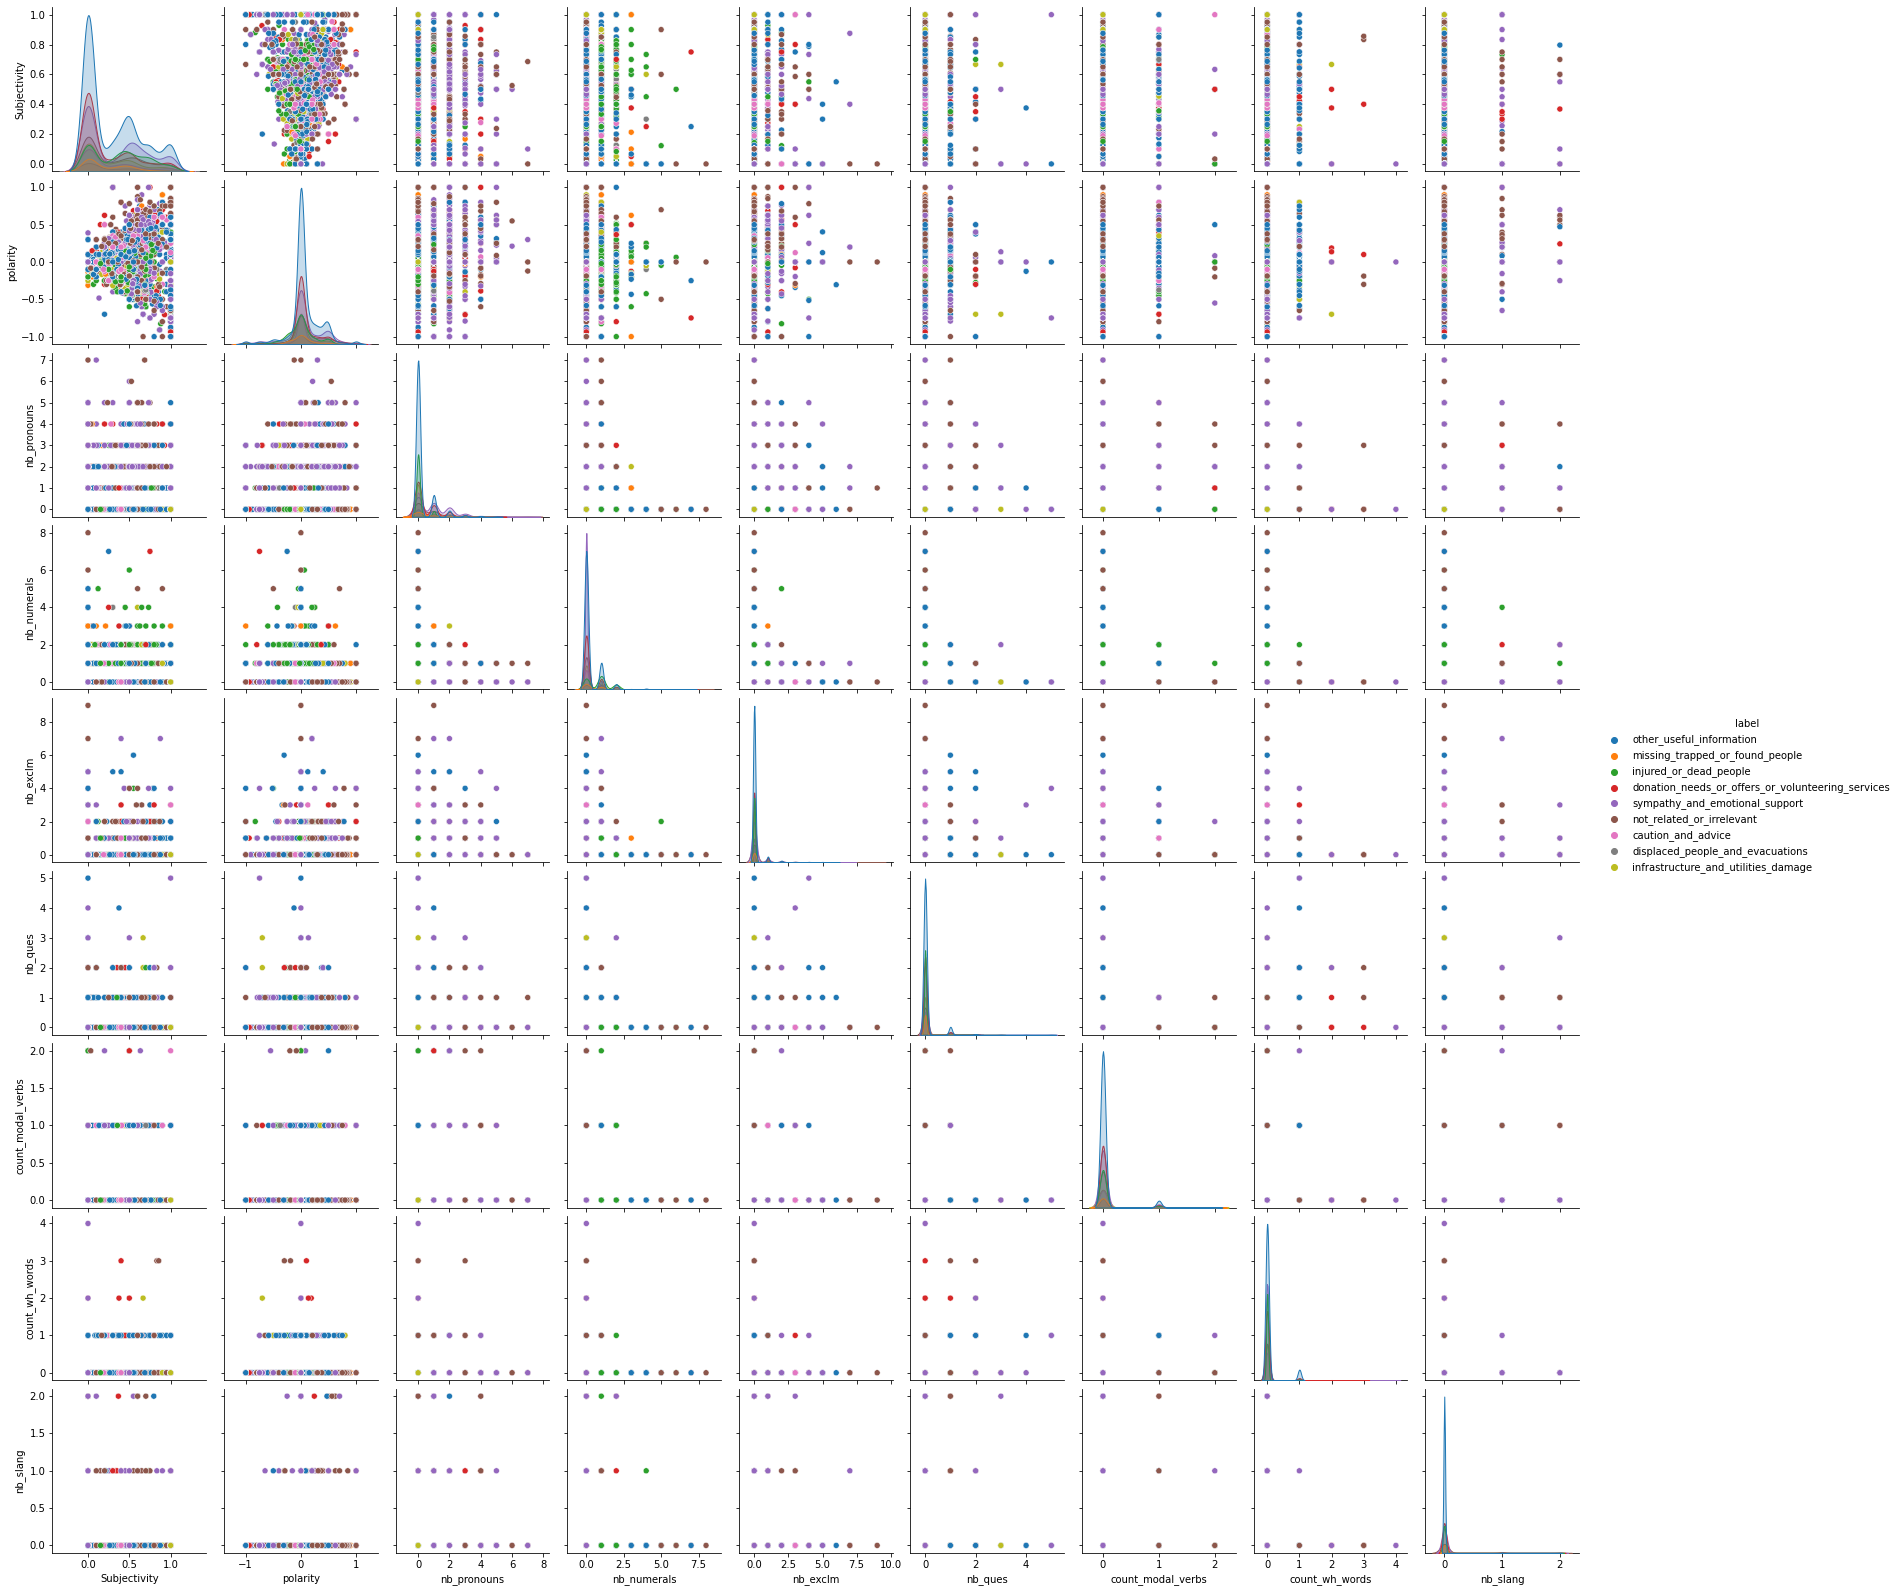

In [30]:
sns.pairplot(eq_df, hue='label', vars=['Subjectivity', 'polarity', 'nb_pronouns',
'nb_numerals', 'nb_exclm', 'nb_ques', 'count_modal_verbs',
'count_wh_words', 'nb_slang'])

In [31]:
svm_clf_rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1)
X = eq_df.drop(['label', 'tweet_text', 'tokenized_text'], axis=1)
y = eq_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)
svm_clf_rbf.fit(X_train, y_train)

rbf_pred = svm_clf_rbf.predict(X_test)

rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))


Accuracy (RBF Kernel):  38.68
F1 (RBF Kernel):  27.39


In [32]:
svm_clf_poly = svm.SVC(kernel='poly', degree=0.5, C=1)
X = eq_df.drop(['label', 'tweet_text', 'tokenized_text'], axis=1)
y = eq_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)
svm_clf_poly.fit(X_train, y_train)

poly_pred = svm_clf_rbf.predict(X_test)

poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (POLY Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (POLY Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (POLY Kernel):  38.68
F1 (POLY Kernel):  27.39


In [33]:
rf_clf = RandomForestClassifier(max_depth=7, random_state=0)
rf_clf.fit(X_train, y_train)

rf_pred = rf_clf.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print('Accuracy (Random Forest): ', "%.2f" % (rf_accuracy*100))
print('F1 (Random Forest): ', "%.2f" % (rf_f1*100))

Accuracy (Random Forest):  41.32
F1 (Random Forest):  32.32


In [35]:
tokens = [nltk.word_tokenize(tweet) for tweet in eq_df['tweet_text'].values]

In [36]:
tokens

[['RT',
  '@',
  'divyaconnects',
  ':',
  'Reached',
  '#',
  'Kathmandu',
  'finally',
  '!',
  'Lots',
  'of',
  'Indians',
  'stranded',
  'at',
  'the',
  'airport',
  '#',
  'NepalQuake',
  '@',
  'BBCHindi',
  'http',
  ':',
  '//t.co/fRpbU9aCKZ'],
 ['fears',
  'for',
  'Foreigners',
  'missing',
  'in',
  'Nepal',
  'earthquake',
  'as',
  'death',
  'toll',
  'soars',
  ':'],
 ['RT',
  '@',
  'ParisBurned',
  ':',
  '3700',
  'people',
  'dead',
  'is',
  'absolutely',
  'devastating',
  'for',
  'a',
  'country',
  'that',
  'is',
  'the',
  'size',
  'of',
  'Oklahoma',
  'on',
  'the',
  'map',
  '.',
  '#',
  'Nepal'],
 ['Earthquake',
  'in',
  'Nepal',
  '-',
  'Please',
  'help',
  'Kapil',
  '#',
  'crowdfunding',
  'fundrazr',
  'Support',
  'and',
  'Retweet',
  'http',
  ':',
  '//t.co/mFEyQ85js9',
  'via',
  'MechanismOfWar'],
 ['Nepal',
  '’',
  's',
  'Slowing',
  'Economy',
  'Set',
  'for',
  'Freefall',
  'Without',
  'World',
  '’',
  's',
  'Help',
  'http',


In [37]:
model = word2vec.Word2Vec(size=32, min_count=1, workers=4)

In [38]:
model.build_vocab(tokens)

2020-11-29 15:33:41,727 : INFO : collecting all words and their counts
2020-11-29 15:33:41,727 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-29 15:33:41,758 : INFO : collected 21748 word types from a corpus of 143056 raw words and 6636 sentences
2020-11-29 15:33:41,758 : INFO : Loading a fresh vocabulary
2020-11-29 15:33:41,794 : INFO : effective_min_count=1 retains 21748 unique words (100% of original 21748, drops 0)
2020-11-29 15:33:41,795 : INFO : effective_min_count=1 leaves 143056 word corpus (100% of original 143056, drops 0)
2020-11-29 15:33:41,851 : INFO : deleting the raw counts dictionary of 21748 items
2020-11-29 15:33:41,852 : INFO : sample=0.001 downsamples 40 most-common words
2020-11-29 15:33:41,852 : INFO : downsampling leaves estimated 102204 word corpus (71.4% of prior 143056)
2020-11-29 15:33:41,891 : INFO : estimated required memory for 21748 words and 32 dimensions: 16441488 bytes
2020-11-29 15:33:41,892 : INFO : resetting layer

In [39]:
model.train(tokens, total_examples=len(tokens), epochs=4000)

2020-11-29 15:33:48,903 : INFO : training model with 4 workers on 21748 vocabulary and 32 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2020-11-29 15:33:48,960 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:48,962 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:48,963 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:48,967 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:48,967 : INFO : EPOCH - 1 : training on 143056 raw words (102149 effective words) took 0.1s, 1755194 effective words/s
2020-11-29 15:33:49,026 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:49,028 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:49,029 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:49,033 : INFO : worker thread finished; awaiting finish of 0 

2020-11-29 15:33:49,968 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:49,969 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:49,973 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:49,974 : INFO : EPOCH - 17 : training on 143056 raw words (102375 effective words) took 0.1s, 1722971 effective words/s
2020-11-29 15:33:50,041 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:50,044 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:50,045 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:50,049 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:50,049 : INFO : EPOCH - 18 : training on 143056 raw words (102207 effective words) took 0.1s, 1501354 effective words/s
2020-11-29 15:33:50,116 : INFO : worker thread finished; awaiting finish of 3 more thread

2020-11-29 15:33:50,893 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:50,893 : INFO : EPOCH - 33 : training on 143056 raw words (102090 effective words) took 0.0s, 2138312 effective words/s
2020-11-29 15:33:50,941 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:50,943 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:50,944 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:50,947 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:50,947 : INFO : EPOCH - 34 : training on 143056 raw words (102347 effective words) took 0.0s, 2154178 effective words/s
2020-11-29 15:33:50,993 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:50,995 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:50,996 : INFO : worker thread finished; awaiting finish of 1 more thread

2020-11-29 15:33:51,783 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:51,785 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:51,785 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:51,788 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:51,789 : INFO : EPOCH - 50 : training on 143056 raw words (102361 effective words) took 0.0s, 2257347 effective words/s
2020-11-29 15:33:51,836 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:51,839 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:51,839 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:51,843 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:51,843 : INFO : EPOCH - 51 : training on 143056 raw words (102156 effective words) took 0.0s, 2120528 effective words/

2020-11-29 15:33:52,628 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:52,630 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:52,631 : INFO : EPOCH - 66 : training on 143056 raw words (102169 effective words) took 0.0s, 2181089 effective words/s
2020-11-29 15:33:52,684 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:52,686 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:52,687 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:52,690 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:52,690 : INFO : EPOCH - 67 : training on 143056 raw words (102245 effective words) took 0.1s, 1931707 effective words/s
2020-11-29 15:33:52,738 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:52,740 : INFO : worker thread finished; awaiting finish of 2 more thread

2020-11-29 15:33:53,503 : INFO : EPOCH - 82 : training on 143056 raw words (102161 effective words) took 0.0s, 2113553 effective words/s
2020-11-29 15:33:53,551 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:53,553 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:53,554 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:53,557 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:53,558 : INFO : EPOCH - 83 : training on 143056 raw words (101958 effective words) took 0.0s, 2113279 effective words/s
2020-11-29 15:33:53,608 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:53,610 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:53,611 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:53,614 : INFO : worker thread finished; awaiting finish of 0 more thread

2020-11-29 15:33:54,463 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:54,464 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:54,466 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:54,467 : INFO : EPOCH - 99 : training on 143056 raw words (102216 effective words) took 0.0s, 2044573 effective words/s
2020-11-29 15:33:54,516 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:54,518 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:54,519 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:54,521 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:54,522 : INFO : EPOCH - 100 : training on 143056 raw words (102067 effective words) took 0.0s, 2107836 effective words/s
2020-11-29 15:33:54,573 : INFO : worker thread finished; awaiting finish of 3 more threa

2020-11-29 15:33:55,366 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:55,367 : INFO : EPOCH - 115 : training on 143056 raw words (102169 effective words) took 0.1s, 1991790 effective words/s
2020-11-29 15:33:55,417 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:55,419 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:55,419 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:55,422 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:55,423 : INFO : EPOCH - 116 : training on 143056 raw words (102455 effective words) took 0.1s, 1994525 effective words/s
2020-11-29 15:33:55,471 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:55,473 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:55,474 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:33:56,301 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:56,303 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:56,304 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:56,307 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:56,307 : INFO : EPOCH - 132 : training on 143056 raw words (102280 effective words) took 0.1s, 1972935 effective words/s
2020-11-29 15:33:56,356 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:56,358 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:56,359 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:56,362 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:56,362 : INFO : EPOCH - 133 : training on 143056 raw words (102092 effective words) took 0.0s, 2115738 effective word

2020-11-29 15:33:57,178 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:57,180 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:57,181 : INFO : EPOCH - 148 : training on 143056 raw words (102201 effective words) took 0.0s, 2173338 effective words/s
2020-11-29 15:33:57,229 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:57,231 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:57,232 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:57,235 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:57,235 : INFO : EPOCH - 149 : training on 143056 raw words (102152 effective words) took 0.0s, 2114997 effective words/s
2020-11-29 15:33:57,280 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:57,282 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:33:58,031 : INFO : EPOCH - 164 : training on 143056 raw words (102189 effective words) took 0.1s, 2010447 effective words/s
2020-11-29 15:33:58,082 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:58,084 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:58,085 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:58,088 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:58,088 : INFO : EPOCH - 165 : training on 143056 raw words (102358 effective words) took 0.1s, 2009244 effective words/s
2020-11-29 15:33:58,137 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:58,140 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:58,140 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:58,143 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:33:58,960 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:58,960 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:58,963 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:58,964 : INFO : EPOCH - 181 : training on 143056 raw words (102287 effective words) took 0.0s, 2145036 effective words/s
2020-11-29 15:33:59,017 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:33:59,020 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:33:59,020 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:33:59,023 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:33:59,023 : INFO : EPOCH - 182 : training on 143056 raw words (102114 effective words) took 0.1s, 1939902 effective words/s
2020-11-29 15:33:59,077 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:34:00,062 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:00,063 : INFO : EPOCH - 197 : training on 143056 raw words (102197 effective words) took 0.1s, 1725988 effective words/s
2020-11-29 15:34:00,116 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:00,119 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:00,119 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:00,122 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:00,123 : INFO : EPOCH - 198 : training on 143056 raw words (102385 effective words) took 0.1s, 1847357 effective words/s
2020-11-29 15:34:00,172 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:00,174 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:00,175 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:34:00,999 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:01,001 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:01,002 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:01,005 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:01,005 : INFO : EPOCH - 214 : training on 143056 raw words (102185 effective words) took 0.0s, 2255165 effective words/s
2020-11-29 15:34:01,055 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:01,057 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:01,058 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:01,060 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:01,061 : INFO : EPOCH - 215 : training on 143056 raw words (102392 effective words) took 0.0s, 2128030 effective word

2020-11-29 15:34:01,862 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:01,865 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:01,865 : INFO : EPOCH - 230 : training on 143056 raw words (102308 effective words) took 0.0s, 2062452 effective words/s
2020-11-29 15:34:01,919 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:01,921 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:01,922 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:01,925 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:01,926 : INFO : EPOCH - 231 : training on 143056 raw words (102064 effective words) took 0.1s, 1903649 effective words/s
2020-11-29 15:34:01,983 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:01,986 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:34:02,841 : INFO : EPOCH - 246 : training on 143056 raw words (102147 effective words) took 0.1s, 1923720 effective words/s
2020-11-29 15:34:02,891 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:02,893 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:02,894 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:02,896 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:02,897 : INFO : EPOCH - 247 : training on 143056 raw words (102297 effective words) took 0.0s, 2072060 effective words/s
2020-11-29 15:34:02,943 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:02,945 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:02,945 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:02,948 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:34:03,792 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:03,793 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:03,796 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:03,797 : INFO : EPOCH - 263 : training on 143056 raw words (102131 effective words) took 0.0s, 2130784 effective words/s
2020-11-29 15:34:03,842 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:03,844 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:03,845 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:03,847 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:03,848 : INFO : EPOCH - 264 : training on 143056 raw words (102154 effective words) took 0.0s, 2264726 effective words/s
2020-11-29 15:34:03,892 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:34:04,642 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:04,643 : INFO : EPOCH - 279 : training on 143056 raw words (102118 effective words) took 0.0s, 2094612 effective words/s
2020-11-29 15:34:04,691 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:04,693 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:04,694 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:04,697 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:04,697 : INFO : EPOCH - 280 : training on 143056 raw words (102106 effective words) took 0.0s, 2107719 effective words/s
2020-11-29 15:34:04,745 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:04,747 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:04,748 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:34:05,530 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:05,532 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:05,533 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:05,535 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:05,536 : INFO : EPOCH - 296 : training on 143056 raw words (102148 effective words) took 0.0s, 2212694 effective words/s
2020-11-29 15:34:05,580 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:05,582 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:05,583 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:05,585 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:05,586 : INFO : EPOCH - 297 : training on 143056 raw words (102262 effective words) took 0.0s, 2331507 effective word

2020-11-29 15:34:06,389 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:06,392 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:06,392 : INFO : EPOCH - 312 : training on 143056 raw words (102153 effective words) took 0.0s, 2266496 effective words/s
2020-11-29 15:34:06,437 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:06,439 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:06,440 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:06,443 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:06,443 : INFO : EPOCH - 313 : training on 143056 raw words (102186 effective words) took 0.0s, 2274722 effective words/s
2020-11-29 15:34:06,487 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:06,489 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:34:07,268 : INFO : EPOCH - 328 : training on 143056 raw words (102218 effective words) took 0.0s, 2087137 effective words/s
2020-11-29 15:34:07,317 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:07,319 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:07,319 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:07,322 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:07,323 : INFO : EPOCH - 329 : training on 143056 raw words (102225 effective words) took 0.0s, 2119515 effective words/s
2020-11-29 15:34:07,370 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:07,372 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:07,373 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:07,376 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:34:08,296 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:08,297 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:08,300 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:08,301 : INFO : EPOCH - 345 : training on 143056 raw words (102117 effective words) took 0.1s, 1642959 effective words/s
2020-11-29 15:34:08,369 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:08,371 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:08,372 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:08,377 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:08,377 : INFO : EPOCH - 346 : training on 143056 raw words (102075 effective words) took 0.1s, 1514051 effective words/s
2020-11-29 15:34:08,442 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:34:09,363 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:09,363 : INFO : EPOCH - 361 : training on 143056 raw words (102239 effective words) took 0.1s, 1382865 effective words/s
2020-11-29 15:34:09,428 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:09,430 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:09,431 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:09,434 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:09,435 : INFO : EPOCH - 362 : training on 143056 raw words (102140 effective words) took 0.1s, 1597929 effective words/s
2020-11-29 15:34:09,496 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:09,498 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:09,499 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:34:10,546 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:10,548 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:10,549 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:10,552 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:10,552 : INFO : EPOCH - 378 : training on 143056 raw words (102351 effective words) took 0.0s, 2133476 effective words/s
2020-11-29 15:34:10,598 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:10,600 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:10,601 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:10,603 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:10,604 : INFO : EPOCH - 379 : training on 143056 raw words (102167 effective words) took 0.0s, 2240232 effective word

2020-11-29 15:34:11,412 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:11,415 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:11,415 : INFO : EPOCH - 394 : training on 143056 raw words (102223 effective words) took 0.1s, 1873843 effective words/s
2020-11-29 15:34:11,469 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:11,471 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:11,474 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:11,474 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:11,475 : INFO : EPOCH - 395 : training on 143056 raw words (102023 effective words) took 0.1s, 1971553 effective words/s
2020-11-29 15:34:11,535 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:11,537 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:34:12,311 : INFO : EPOCH - 410 : training on 143056 raw words (102120 effective words) took 0.0s, 2164176 effective words/s
2020-11-29 15:34:12,359 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:12,361 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:12,362 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:12,364 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:12,365 : INFO : EPOCH - 411 : training on 143056 raw words (102138 effective words) took 0.0s, 2156989 effective words/s
2020-11-29 15:34:12,410 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:12,412 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:12,413 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:12,415 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:34:13,185 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:13,186 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:13,188 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:13,189 : INFO : EPOCH - 427 : training on 143056 raw words (102278 effective words) took 0.0s, 2278368 effective words/s
2020-11-29 15:34:13,234 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:13,236 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:13,237 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:13,239 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:13,240 : INFO : EPOCH - 428 : training on 143056 raw words (102210 effective words) took 0.0s, 2196466 effective words/s
2020-11-29 15:34:13,285 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:34:14,065 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:14,065 : INFO : EPOCH - 443 : training on 143056 raw words (102240 effective words) took 0.0s, 2238777 effective words/s
2020-11-29 15:34:14,110 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:14,112 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:14,113 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:14,115 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:14,116 : INFO : EPOCH - 444 : training on 143056 raw words (102106 effective words) took 0.0s, 2285961 effective words/s
2020-11-29 15:34:14,160 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:14,162 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:14,163 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:34:14,949 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:14,951 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:14,952 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:14,954 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:14,955 : INFO : EPOCH - 460 : training on 143056 raw words (102098 effective words) took 0.0s, 2315830 effective words/s
2020-11-29 15:34:15,000 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:15,002 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:15,003 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:15,006 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:15,007 : INFO : EPOCH - 461 : training on 143056 raw words (102122 effective words) took 0.0s, 2220301 effective word

2020-11-29 15:34:15,802 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:15,804 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:15,805 : INFO : EPOCH - 476 : training on 143056 raw words (102299 effective words) took 0.0s, 2188210 effective words/s
2020-11-29 15:34:15,850 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:15,852 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:15,853 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:15,856 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:15,856 : INFO : EPOCH - 477 : training on 143056 raw words (102146 effective words) took 0.0s, 2268391 effective words/s
2020-11-29 15:34:15,901 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:15,903 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:34:16,627 : INFO : EPOCH - 492 : training on 143056 raw words (102321 effective words) took 0.0s, 2367434 effective words/s
2020-11-29 15:34:16,671 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:16,673 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:16,674 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:16,676 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:16,677 : INFO : EPOCH - 493 : training on 143056 raw words (102127 effective words) took 0.0s, 2321293 effective words/s
2020-11-29 15:34:16,721 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:16,723 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:16,724 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:16,726 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:34:17,546 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:17,547 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:17,550 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:17,550 : INFO : EPOCH - 509 : training on 143056 raw words (102068 effective words) took 0.0s, 2137878 effective words/s
2020-11-29 15:34:17,598 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:17,600 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:17,601 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:17,604 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:17,604 : INFO : EPOCH - 510 : training on 143056 raw words (102103 effective words) took 0.0s, 2134827 effective words/s
2020-11-29 15:34:17,651 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:34:18,401 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:18,401 : INFO : EPOCH - 525 : training on 143056 raw words (102148 effective words) took 0.0s, 2070483 effective words/s
2020-11-29 15:34:18,447 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:18,449 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:18,450 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:18,453 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:18,453 : INFO : EPOCH - 526 : training on 143056 raw words (102284 effective words) took 0.0s, 2262257 effective words/s
2020-11-29 15:34:18,499 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:18,500 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:18,501 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:34:19,294 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:19,296 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:19,297 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:19,300 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:19,300 : INFO : EPOCH - 542 : training on 143056 raw words (102137 effective words) took 0.0s, 2149813 effective words/s
2020-11-29 15:34:19,348 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:19,350 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:19,351 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:19,354 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:19,354 : INFO : EPOCH - 543 : training on 143056 raw words (102160 effective words) took 0.0s, 2151576 effective word

2020-11-29 15:34:20,201 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:20,203 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:20,204 : INFO : EPOCH - 558 : training on 143056 raw words (102084 effective words) took 0.0s, 2232325 effective words/s
2020-11-29 15:34:20,251 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:20,253 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:20,254 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:20,257 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:20,257 : INFO : EPOCH - 559 : training on 143056 raw words (102046 effective words) took 0.0s, 2149665 effective words/s
2020-11-29 15:34:20,310 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:20,312 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:34:21,069 : INFO : EPOCH - 574 : training on 143056 raw words (102169 effective words) took 0.0s, 2120126 effective words/s
2020-11-29 15:34:21,115 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:21,117 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:21,118 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:21,120 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:21,121 : INFO : EPOCH - 575 : training on 143056 raw words (102348 effective words) took 0.0s, 2277973 effective words/s
2020-11-29 15:34:21,186 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:21,188 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:21,189 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:21,191 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:34:21,976 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:21,976 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:21,979 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:21,979 : INFO : EPOCH - 591 : training on 143056 raw words (102122 effective words) took 0.0s, 2185862 effective words/s
2020-11-29 15:34:22,028 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:22,030 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:22,031 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:22,034 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:22,034 : INFO : EPOCH - 592 : training on 143056 raw words (102124 effective words) took 0.1s, 2033265 effective words/s
2020-11-29 15:34:22,080 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:34:22,974 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:22,975 : INFO : EPOCH - 607 : training on 143056 raw words (102274 effective words) took 0.1s, 1469658 effective words/s
2020-11-29 15:34:23,039 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:23,042 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:23,043 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:23,046 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:23,047 : INFO : EPOCH - 608 : training on 143056 raw words (102258 effective words) took 0.1s, 1569546 effective words/s
2020-11-29 15:34:23,106 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:23,108 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:23,110 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:34:23,984 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:23,986 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:23,987 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:23,990 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:23,990 : INFO : EPOCH - 624 : training on 143056 raw words (102303 effective words) took 0.0s, 2153860 effective words/s
2020-11-29 15:34:24,040 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:24,042 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:24,042 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:24,045 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:24,046 : INFO : EPOCH - 625 : training on 143056 raw words (102214 effective words) took 0.1s, 1991263 effective word

2020-11-29 15:34:24,838 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:24,841 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:24,841 : INFO : EPOCH - 640 : training on 143056 raw words (102421 effective words) took 0.0s, 2199292 effective words/s
2020-11-29 15:34:24,886 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:24,888 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:24,889 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:24,891 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:24,892 : INFO : EPOCH - 641 : training on 143056 raw words (102139 effective words) took 0.0s, 2338985 effective words/s
2020-11-29 15:34:24,938 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:24,941 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:34:25,741 : INFO : EPOCH - 656 : training on 143056 raw words (101992 effective words) took 0.0s, 2177692 effective words/s
2020-11-29 15:34:25,788 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:25,790 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:25,790 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:25,793 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:25,794 : INFO : EPOCH - 657 : training on 143056 raw words (102136 effective words) took 0.0s, 2196439 effective words/s
2020-11-29 15:34:25,841 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:25,843 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:25,844 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:25,847 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:34:26,620 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:26,621 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:26,624 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:26,624 : INFO : EPOCH - 673 : training on 143056 raw words (102389 effective words) took 0.0s, 2461545 effective words/s
2020-11-29 15:34:26,668 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:26,670 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:26,671 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:26,674 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:26,674 : INFO : EPOCH - 674 : training on 143056 raw words (102001 effective words) took 0.0s, 2334695 effective words/s
2020-11-29 15:34:26,719 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:34:27,452 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:27,453 : INFO : EPOCH - 689 : training on 143056 raw words (102165 effective words) took 0.0s, 2332273 effective words/s
2020-11-29 15:34:27,498 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:27,500 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:27,501 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:27,503 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:27,504 : INFO : EPOCH - 690 : training on 143056 raw words (102138 effective words) took 0.0s, 2275289 effective words/s
2020-11-29 15:34:27,549 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:27,551 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:27,552 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:34:28,319 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:28,321 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:28,322 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:28,325 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:28,325 : INFO : EPOCH - 706 : training on 143056 raw words (102167 effective words) took 0.0s, 2300480 effective words/s
2020-11-29 15:34:28,372 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:28,374 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:28,375 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:28,377 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:28,378 : INFO : EPOCH - 707 : training on 143056 raw words (102430 effective words) took 0.0s, 2201043 effective word

2020-11-29 15:34:29,175 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:29,178 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:29,178 : INFO : EPOCH - 722 : training on 143056 raw words (102234 effective words) took 0.0s, 2280041 effective words/s
2020-11-29 15:34:29,224 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:29,226 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:29,227 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:29,229 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:29,230 : INFO : EPOCH - 723 : training on 143056 raw words (102199 effective words) took 0.0s, 2254413 effective words/s
2020-11-29 15:34:29,276 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:29,277 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:34:30,019 : INFO : EPOCH - 738 : training on 143056 raw words (102224 effective words) took 0.0s, 2209270 effective words/s
2020-11-29 15:34:30,064 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:30,067 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:30,067 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:30,070 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:30,070 : INFO : EPOCH - 739 : training on 143056 raw words (101996 effective words) took 0.0s, 2301428 effective words/s
2020-11-29 15:34:30,115 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:30,117 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:30,118 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:30,120 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:34:30,876 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:30,876 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:30,879 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:30,879 : INFO : EPOCH - 755 : training on 143056 raw words (102169 effective words) took 0.0s, 2336290 effective words/s
2020-11-29 15:34:30,925 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:30,927 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:30,928 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:30,930 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:30,930 : INFO : EPOCH - 756 : training on 143056 raw words (102179 effective words) took 0.0s, 2264492 effective words/s
2020-11-29 15:34:30,975 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:34:31,749 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:31,749 : INFO : EPOCH - 771 : training on 143056 raw words (102220 effective words) took 0.0s, 2168337 effective words/s
2020-11-29 15:34:31,800 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:31,801 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:31,802 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:31,805 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:31,805 : INFO : EPOCH - 772 : training on 143056 raw words (102305 effective words) took 0.0s, 2077959 effective words/s
2020-11-29 15:34:31,851 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:31,852 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:31,853 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:34:32,648 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:32,650 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:32,651 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:32,654 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:32,654 : INFO : EPOCH - 788 : training on 143056 raw words (102293 effective words) took 0.0s, 2246466 effective words/s
2020-11-29 15:34:32,699 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:32,701 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:32,702 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:32,704 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:32,705 : INFO : EPOCH - 789 : training on 143056 raw words (102309 effective words) took 0.0s, 2314847 effective word

2020-11-29 15:34:33,578 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:33,580 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:33,581 : INFO : EPOCH - 804 : training on 143056 raw words (102386 effective words) took 0.1s, 1924730 effective words/s
2020-11-29 15:34:33,630 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:33,632 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:33,633 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:33,635 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:33,636 : INFO : EPOCH - 805 : training on 143056 raw words (102297 effective words) took 0.0s, 2095533 effective words/s
2020-11-29 15:34:33,685 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:33,687 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:34:34,552 : INFO : EPOCH - 820 : training on 143056 raw words (102288 effective words) took 0.1s, 1688846 effective words/s
2020-11-29 15:34:34,621 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:34,624 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:34,625 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:34,628 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:34,629 : INFO : EPOCH - 821 : training on 143056 raw words (102250 effective words) took 0.1s, 1502139 effective words/s
2020-11-29 15:34:34,719 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:34,728 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:34,729 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:34,734 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:34:35,917 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:35,918 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:35,922 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:35,923 : INFO : EPOCH - 837 : training on 143056 raw words (102085 effective words) took 0.1s, 1342487 effective words/s
2020-11-29 15:34:35,981 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:35,984 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:35,985 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:35,987 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:35,988 : INFO : EPOCH - 838 : training on 143056 raw words (102306 effective words) took 0.1s, 1728744 effective words/s
2020-11-29 15:34:36,048 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:34:37,036 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:37,036 : INFO : EPOCH - 853 : training on 143056 raw words (102136 effective words) took 0.1s, 1897767 effective words/s
2020-11-29 15:34:37,096 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:37,098 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:37,099 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:37,103 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:37,103 : INFO : EPOCH - 854 : training on 143056 raw words (102226 effective words) took 0.1s, 1718525 effective words/s
2020-11-29 15:34:37,161 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:37,164 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:37,164 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:34:38,125 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:38,128 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:38,128 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:38,131 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:38,132 : INFO : EPOCH - 870 : training on 143056 raw words (102099 effective words) took 0.1s, 1736925 effective words/s
2020-11-29 15:34:38,190 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:38,192 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:38,192 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:38,196 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:38,196 : INFO : EPOCH - 871 : training on 143056 raw words (102168 effective words) took 0.0s, 2109682 effective word

2020-11-29 15:34:39,163 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:39,165 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:39,166 : INFO : EPOCH - 886 : training on 143056 raw words (102294 effective words) took 0.1s, 1754649 effective words/s
2020-11-29 15:34:39,219 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:39,222 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:39,223 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:39,225 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:39,226 : INFO : EPOCH - 887 : training on 143056 raw words (102076 effective words) took 0.1s, 1932848 effective words/s
2020-11-29 15:34:39,280 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:39,282 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:34:40,249 : INFO : EPOCH - 902 : training on 143056 raw words (102410 effective words) took 0.1s, 1622727 effective words/s
2020-11-29 15:34:40,309 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:40,312 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:40,313 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:40,315 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:40,316 : INFO : EPOCH - 903 : training on 143056 raw words (102272 effective words) took 0.1s, 1672290 effective words/s
2020-11-29 15:34:40,372 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:40,374 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:40,375 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:40,379 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:34:41,381 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:41,382 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:41,384 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:41,385 : INFO : EPOCH - 919 : training on 143056 raw words (102229 effective words) took 0.1s, 1712717 effective words/s
2020-11-29 15:34:41,440 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:41,443 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:41,444 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:41,447 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:41,448 : INFO : EPOCH - 920 : training on 143056 raw words (102253 effective words) took 0.1s, 1831945 effective words/s
2020-11-29 15:34:41,502 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:34:42,432 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:42,432 : INFO : EPOCH - 935 : training on 143056 raw words (102289 effective words) took 0.1s, 1618010 effective words/s
2020-11-29 15:34:42,489 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:42,492 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:42,492 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:42,496 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:42,497 : INFO : EPOCH - 936 : training on 143056 raw words (102137 effective words) took 0.1s, 1798061 effective words/s
2020-11-29 15:34:42,553 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:42,556 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:42,556 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:34:43,542 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:43,544 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:43,546 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:43,548 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:43,549 : INFO : EPOCH - 952 : training on 143056 raw words (102065 effective words) took 0.1s, 1815691 effective words/s
2020-11-29 15:34:43,610 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:43,612 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:43,613 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:43,616 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:43,617 : INFO : EPOCH - 953 : training on 143056 raw words (102452 effective words) took 0.1s, 1673834 effective word

2020-11-29 15:34:44,666 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:44,671 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:44,671 : INFO : EPOCH - 968 : training on 143056 raw words (102367 effective words) took 0.1s, 1358914 effective words/s
2020-11-29 15:34:44,735 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:44,737 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:44,738 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:44,741 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:44,742 : INFO : EPOCH - 969 : training on 143056 raw words (102197 effective words) took 0.1s, 1592043 effective words/s
2020-11-29 15:34:44,796 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:44,798 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:34:45,722 : INFO : EPOCH - 984 : training on 143056 raw words (102109 effective words) took 0.1s, 1976340 effective words/s
2020-11-29 15:34:45,769 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:45,771 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:45,772 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:45,774 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:45,775 : INFO : EPOCH - 985 : training on 143056 raw words (102153 effective words) took 0.0s, 2190655 effective words/s
2020-11-29 15:34:45,821 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:45,824 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:45,824 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:45,827 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:34:46,841 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:46,842 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:46,846 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:46,846 : INFO : EPOCH - 1001 : training on 143056 raw words (101964 effective words) took 0.1s, 1610656 effective words/s
2020-11-29 15:34:46,914 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:46,918 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:46,919 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:46,922 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:46,922 : INFO : EPOCH - 1002 : training on 143056 raw words (102290 effective words) took 0.1s, 1523888 effective words/s
2020-11-29 15:34:46,989 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:34:47,955 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:47,956 : INFO : EPOCH - 1017 : training on 143056 raw words (102234 effective words) took 0.1s, 1516900 effective words/s
2020-11-29 15:34:48,027 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:48,030 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:48,030 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:48,034 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:48,034 : INFO : EPOCH - 1018 : training on 143056 raw words (102098 effective words) took 0.1s, 1489001 effective words/s
2020-11-29 15:34:48,096 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:48,099 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:48,100 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:34:49,041 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:49,044 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:49,045 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:49,047 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:49,048 : INFO : EPOCH - 1034 : training on 143056 raw words (102424 effective words) took 0.1s, 1771293 effective words/s
2020-11-29 15:34:49,105 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:49,108 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:49,108 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:49,111 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:49,112 : INFO : EPOCH - 1035 : training on 143056 raw words (102080 effective words) took 0.1s, 1802522 effective wo

2020-11-29 15:34:50,137 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:50,140 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:50,141 : INFO : EPOCH - 1050 : training on 143056 raw words (102151 effective words) took 0.1s, 1806363 effective words/s
2020-11-29 15:34:50,197 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:50,200 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:50,201 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:50,204 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:50,204 : INFO : EPOCH - 1051 : training on 143056 raw words (102037 effective words) took 0.1s, 1819096 effective words/s
2020-11-29 15:34:50,261 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:50,263 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:34:51,197 : INFO : EPOCH - 1066 : training on 143056 raw words (102139 effective words) took 0.1s, 1562451 effective words/s
2020-11-29 15:34:51,259 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:51,261 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:51,262 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:51,265 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:51,265 : INFO : EPOCH - 1067 : training on 143056 raw words (101950 effective words) took 0.1s, 1675712 effective words/s
2020-11-29 15:34:51,322 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:51,325 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:51,326 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:51,329 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:34:52,274 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:52,275 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:52,278 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:52,279 : INFO : EPOCH - 1083 : training on 143056 raw words (101948 effective words) took 0.1s, 1765521 effective words/s
2020-11-29 15:34:52,345 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:52,348 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:52,350 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:52,354 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:52,354 : INFO : EPOCH - 1084 : training on 143056 raw words (102092 effective words) took 0.1s, 1486009 effective words/s
2020-11-29 15:34:52,417 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:34:53,404 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:53,405 : INFO : EPOCH - 1099 : training on 143056 raw words (102324 effective words) took 0.1s, 1865307 effective words/s
2020-11-29 15:34:53,462 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:53,464 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:53,465 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:53,468 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:53,468 : INFO : EPOCH - 1100 : training on 143056 raw words (102196 effective words) took 0.1s, 1801060 effective words/s
2020-11-29 15:34:53,526 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:53,528 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:53,529 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:34:54,484 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:54,486 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:54,487 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:54,490 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:54,491 : INFO : EPOCH - 1116 : training on 143056 raw words (102051 effective words) took 0.1s, 1789879 effective words/s
2020-11-29 15:34:54,544 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:54,546 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:54,547 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:54,551 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:54,551 : INFO : EPOCH - 1117 : training on 143056 raw words (102285 effective words) took 0.1s, 1914584 effective wo

2020-11-29 15:34:55,549 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:55,552 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:55,552 : INFO : EPOCH - 1132 : training on 143056 raw words (102086 effective words) took 0.1s, 1944629 effective words/s
2020-11-29 15:34:55,610 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:55,612 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:55,613 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:55,616 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:55,617 : INFO : EPOCH - 1133 : training on 143056 raw words (102142 effective words) took 0.1s, 1775125 effective words/s
2020-11-29 15:34:55,672 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:55,675 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:34:56,570 : INFO : EPOCH - 1148 : training on 143056 raw words (101997 effective words) took 0.1s, 1938267 effective words/s
2020-11-29 15:34:56,625 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:56,628 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:56,631 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:56,632 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:56,632 : INFO : EPOCH - 1149 : training on 143056 raw words (102132 effective words) took 0.1s, 1838252 effective words/s
2020-11-29 15:34:56,695 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:56,697 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:56,698 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:56,701 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:34:57,732 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:57,733 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:57,737 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:57,737 : INFO : EPOCH - 1165 : training on 143056 raw words (102236 effective words) took 0.1s, 1705550 effective words/s
2020-11-29 15:34:57,796 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:57,798 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:57,799 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:57,802 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:57,803 : INFO : EPOCH - 1166 : training on 143056 raw words (102163 effective words) took 0.1s, 1759288 effective words/s
2020-11-29 15:34:57,861 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:34:58,781 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:58,781 : INFO : EPOCH - 1181 : training on 143056 raw words (102049 effective words) took 0.0s, 2064417 effective words/s
2020-11-29 15:34:58,834 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:58,837 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:58,838 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:58,841 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:58,841 : INFO : EPOCH - 1182 : training on 143056 raw words (102303 effective words) took 0.1s, 1925645 effective words/s
2020-11-29 15:34:58,893 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:58,895 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:58,896 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:34:59,822 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:59,825 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:59,826 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:59,828 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:59,829 : INFO : EPOCH - 1198 : training on 143056 raw words (102134 effective words) took 0.1s, 2015557 effective words/s
2020-11-29 15:34:59,877 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:34:59,879 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:34:59,880 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:34:59,882 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:34:59,883 : INFO : EPOCH - 1199 : training on 143056 raw words (102294 effective words) took 0.0s, 2139123 effective wo

2020-11-29 15:35:00,712 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:00,715 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:00,715 : INFO : EPOCH - 1214 : training on 143056 raw words (102038 effective words) took 0.0s, 2065373 effective words/s
2020-11-29 15:35:00,764 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:00,766 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:00,766 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:00,769 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:00,769 : INFO : EPOCH - 1215 : training on 143056 raw words (102229 effective words) took 0.0s, 2060510 effective words/s
2020-11-29 15:35:00,817 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:00,819 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:35:01,642 : INFO : EPOCH - 1230 : training on 143056 raw words (102201 effective words) took 0.1s, 2031173 effective words/s
2020-11-29 15:35:01,692 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:01,695 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:01,695 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:01,698 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:01,698 : INFO : EPOCH - 1231 : training on 143056 raw words (102007 effective words) took 0.0s, 2065803 effective words/s
2020-11-29 15:35:01,749 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:01,752 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:01,752 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:01,755 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:35:02,604 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:02,604 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:02,607 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:02,608 : INFO : EPOCH - 1247 : training on 143056 raw words (102096 effective words) took 0.0s, 2125161 effective words/s
2020-11-29 15:35:02,658 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:02,660 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:02,661 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:02,663 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:02,664 : INFO : EPOCH - 1248 : training on 143056 raw words (102224 effective words) took 0.0s, 2050210 effective words/s
2020-11-29 15:35:02,711 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:35:03,498 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:03,498 : INFO : EPOCH - 1263 : training on 143056 raw words (101981 effective words) took 0.0s, 2070954 effective words/s
2020-11-29 15:35:03,547 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:03,549 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:03,550 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:03,553 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:03,553 : INFO : EPOCH - 1264 : training on 143056 raw words (102334 effective words) took 0.0s, 2113829 effective words/s
2020-11-29 15:35:03,602 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:03,604 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:03,604 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:35:04,456 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:04,458 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:04,459 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:04,462 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:04,463 : INFO : EPOCH - 1280 : training on 143056 raw words (102289 effective words) took 0.0s, 2099035 effective words/s
2020-11-29 15:35:04,516 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:04,518 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:04,519 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:04,522 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:04,522 : INFO : EPOCH - 1281 : training on 143056 raw words (102140 effective words) took 0.1s, 1945486 effective wo

2020-11-29 15:35:05,500 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:05,503 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:05,503 : INFO : EPOCH - 1296 : training on 143056 raw words (102276 effective words) took 0.1s, 1868583 effective words/s
2020-11-29 15:35:05,560 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:05,563 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:05,564 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:05,567 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:05,567 : INFO : EPOCH - 1297 : training on 143056 raw words (102222 effective words) took 0.1s, 1811548 effective words/s
2020-11-29 15:35:05,618 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:05,620 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:35:06,575 : INFO : EPOCH - 1312 : training on 143056 raw words (102136 effective words) took 0.1s, 1586025 effective words/s
2020-11-29 15:35:06,634 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:06,636 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:06,637 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:06,641 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:06,642 : INFO : EPOCH - 1313 : training on 143056 raw words (102335 effective words) took 0.1s, 1751545 effective words/s
2020-11-29 15:35:06,700 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:06,703 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:06,703 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:06,706 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:35:07,770 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:07,771 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:07,774 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:07,774 : INFO : EPOCH - 1329 : training on 143056 raw words (102301 effective words) took 0.1s, 1685041 effective words/s
2020-11-29 15:35:07,841 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:07,844 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:07,844 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:07,848 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:07,849 : INFO : EPOCH - 1330 : training on 143056 raw words (102139 effective words) took 0.1s, 1530239 effective words/s
2020-11-29 15:35:07,918 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:35:08,915 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:08,916 : INFO : EPOCH - 1345 : training on 143056 raw words (102341 effective words) took 0.1s, 1656808 effective words/s
2020-11-29 15:35:08,980 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:08,983 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:08,984 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:08,987 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:08,988 : INFO : EPOCH - 1346 : training on 143056 raw words (102223 effective words) took 0.1s, 1602767 effective words/s
2020-11-29 15:35:09,049 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:09,052 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:09,053 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:35:10,140 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:10,142 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:10,143 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:10,148 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:10,149 : INFO : EPOCH - 1362 : training on 143056 raw words (102283 effective words) took 0.1s, 1487753 effective words/s
2020-11-29 15:35:10,211 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:10,214 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:10,215 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:10,219 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:10,219 : INFO : EPOCH - 1363 : training on 143056 raw words (102252 effective words) took 0.1s, 1653715 effective wo

2020-11-29 15:35:11,308 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:11,312 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:11,312 : INFO : EPOCH - 1378 : training on 143056 raw words (102087 effective words) took 0.1s, 1595704 effective words/s
2020-11-29 15:35:11,381 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:11,384 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:11,385 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:11,389 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:11,389 : INFO : EPOCH - 1379 : training on 143056 raw words (102147 effective words) took 0.1s, 1498795 effective words/s
2020-11-29 15:35:11,454 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:11,457 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:35:12,487 : INFO : EPOCH - 1394 : training on 143056 raw words (102255 effective words) took 0.1s, 1627317 effective words/s
2020-11-29 15:35:12,553 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:12,556 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:12,557 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:12,561 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:12,562 : INFO : EPOCH - 1395 : training on 143056 raw words (102179 effective words) took 0.1s, 1530440 effective words/s
2020-11-29 15:35:12,648 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:12,652 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:12,652 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:12,656 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:35:13,811 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:13,812 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:13,816 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:13,816 : INFO : EPOCH - 1411 : training on 143056 raw words (102275 effective words) took 0.1s, 1522741 effective words/s
2020-11-29 15:35:13,883 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:13,886 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:13,887 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:13,891 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:13,892 : INFO : EPOCH - 1412 : training on 143056 raw words (102094 effective words) took 0.1s, 1529913 effective words/s
2020-11-29 15:35:13,962 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:35:15,129 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:15,130 : INFO : EPOCH - 1427 : training on 143056 raw words (102288 effective words) took 0.1s, 1385842 effective words/s
2020-11-29 15:35:15,206 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:15,210 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:15,211 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:15,215 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:15,216 : INFO : EPOCH - 1428 : training on 143056 raw words (102108 effective words) took 0.1s, 1329374 effective words/s
2020-11-29 15:35:15,292 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:15,295 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:15,297 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:35:16,599 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:16,603 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:16,604 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:16,607 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:16,608 : INFO : EPOCH - 1444 : training on 143056 raw words (102214 effective words) took 0.1s, 1239230 effective words/s
2020-11-29 15:35:16,724 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:16,727 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:16,729 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:16,733 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:16,734 : INFO : EPOCH - 1445 : training on 143056 raw words (102280 effective words) took 0.1s, 887586 effective wor

2020-11-29 15:35:18,225 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:18,229 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:18,230 : INFO : EPOCH - 1460 : training on 143056 raw words (102173 effective words) took 0.1s, 1251166 effective words/s
2020-11-29 15:35:18,311 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:18,315 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:18,316 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:18,321 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:18,321 : INFO : EPOCH - 1461 : training on 143056 raw words (102237 effective words) took 0.1s, 1269367 effective words/s
2020-11-29 15:35:18,403 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:18,406 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:35:19,764 : INFO : EPOCH - 1476 : training on 143056 raw words (102290 effective words) took 0.1s, 1109338 effective words/s
2020-11-29 15:35:19,849 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:19,853 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:19,854 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:19,859 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:19,860 : INFO : EPOCH - 1477 : training on 143056 raw words (102246 effective words) took 0.1s, 1273018 effective words/s
2020-11-29 15:35:19,938 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:19,941 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:19,943 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:19,947 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:35:21,412 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:21,413 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:21,418 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:21,419 : INFO : EPOCH - 1493 : training on 143056 raw words (102146 effective words) took 0.1s, 1105564 effective words/s
2020-11-29 15:35:21,507 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:21,511 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:21,512 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:21,518 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:21,519 : INFO : EPOCH - 1494 : training on 143056 raw words (102065 effective words) took 0.1s, 1141068 effective words/s
2020-11-29 15:35:21,606 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:35:23,141 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:23,142 : INFO : EPOCH - 1509 : training on 143056 raw words (102140 effective words) took 0.1s, 1106207 effective words/s
2020-11-29 15:35:23,243 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:23,248 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:23,249 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:23,256 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:23,257 : INFO : EPOCH - 1510 : training on 143056 raw words (102213 effective words) took 0.1s, 1111826 effective words/s
2020-11-29 15:35:23,361 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:23,365 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:23,366 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:35:25,063 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:25,069 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:25,070 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:25,074 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:25,075 : INFO : EPOCH - 1526 : training on 143056 raw words (102237 effective words) took 0.1s, 1060867 effective words/s
2020-11-29 15:35:25,169 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:25,173 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:25,174 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:25,180 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:25,180 : INFO : EPOCH - 1527 : training on 143056 raw words (102063 effective words) took 0.1s, 1101920 effective wo

2020-11-29 15:35:26,902 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:26,908 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:26,909 : INFO : EPOCH - 1542 : training on 143056 raw words (102279 effective words) took 0.1s, 951690 effective words/s
2020-11-29 15:35:27,007 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:27,013 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:27,015 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:27,020 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:27,021 : INFO : EPOCH - 1543 : training on 143056 raw words (102124 effective words) took 0.1s, 988512 effective words/s
2020-11-29 15:35:27,136 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:27,140 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:35:28,943 : INFO : EPOCH - 1558 : training on 143056 raw words (102255 effective words) took 0.1s, 811516 effective words/s
2020-11-29 15:35:29,059 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:29,065 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:29,067 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:29,073 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:29,073 : INFO : EPOCH - 1559 : training on 143056 raw words (102109 effective words) took 0.1s, 835402 effective words/s
2020-11-29 15:35:29,182 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:29,186 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:29,188 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:29,194 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:35:31,381 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:31,383 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:31,389 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:31,390 : INFO : EPOCH - 1575 : training on 143056 raw words (102207 effective words) took 0.1s, 914683 effective words/s
2020-11-29 15:35:31,505 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:31,511 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:31,513 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:31,519 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:31,520 : INFO : EPOCH - 1576 : training on 143056 raw words (102329 effective words) took 0.1s, 886163 effective words/s
2020-11-29 15:35:31,635 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:35:33,476 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:33,477 : INFO : EPOCH - 1591 : training on 143056 raw words (102147 effective words) took 0.1s, 917795 effective words/s
2020-11-29 15:35:33,580 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:33,584 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:33,586 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:33,591 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:33,592 : INFO : EPOCH - 1592 : training on 143056 raw words (102237 effective words) took 0.1s, 996397 effective words/s
2020-11-29 15:35:33,694 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:33,699 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:33,701 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:35:35,564 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:35,569 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:35,572 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:35,577 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:35,578 : INFO : EPOCH - 1608 : training on 143056 raw words (101995 effective words) took 0.1s, 871227 effective words/s
2020-11-29 15:35:35,689 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:35,693 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:35,695 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:35,701 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:35,702 : INFO : EPOCH - 1609 : training on 143056 raw words (102207 effective words) took 0.1s, 931402 effective word

2020-11-29 15:35:37,661 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:37,666 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:37,667 : INFO : EPOCH - 1624 : training on 143056 raw words (102289 effective words) took 0.1s, 899300 effective words/s
2020-11-29 15:35:37,777 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:37,783 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:37,784 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:37,791 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:37,792 : INFO : EPOCH - 1625 : training on 143056 raw words (102269 effective words) took 0.1s, 917173 effective words/s
2020-11-29 15:35:37,905 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:37,910 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:35:39,659 : INFO : EPOCH - 1640 : training on 143056 raw words (102165 effective words) took 0.1s, 730950 effective words/s
2020-11-29 15:35:39,811 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:39,817 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:39,823 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:39,835 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:39,836 : INFO : EPOCH - 1641 : training on 143056 raw words (102283 effective words) took 0.1s, 729751 effective words/s
2020-11-29 15:35:39,980 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:39,986 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:39,988 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:39,996 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:35:42,132 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:42,133 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:42,140 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:42,141 : INFO : EPOCH - 1657 : training on 143056 raw words (102134 effective words) took 0.1s, 902303 effective words/s
2020-11-29 15:35:42,263 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:42,270 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:42,271 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:42,278 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:42,279 : INFO : EPOCH - 1658 : training on 143056 raw words (102270 effective words) took 0.1s, 821587 effective words/s
2020-11-29 15:35:42,404 : INFO : worker thread finished; awaiting finish of 3 more thre

2020-11-29 15:35:44,292 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:44,293 : INFO : EPOCH - 1673 : training on 143056 raw words (102253 effective words) took 0.1s, 884047 effective words/s
2020-11-29 15:35:44,400 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:44,404 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:44,406 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:44,413 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:44,414 : INFO : EPOCH - 1674 : training on 143056 raw words (102174 effective words) took 0.1s, 947319 effective words/s
2020-11-29 15:35:44,521 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:44,526 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:44,528 : INFO : worker thread finished; awaiting finish of 1 more thre

2020-11-29 15:35:46,600 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:46,605 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:46,607 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:46,614 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:46,615 : INFO : EPOCH - 1690 : training on 143056 raw words (102168 effective words) took 0.1s, 802250 effective words/s
2020-11-29 15:35:46,732 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:46,738 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:46,741 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:46,747 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:46,748 : INFO : EPOCH - 1691 : training on 143056 raw words (102081 effective words) took 0.1s, 863498 effective word

2020-11-29 15:35:48,870 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:48,876 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:48,877 : INFO : EPOCH - 1706 : training on 143056 raw words (102012 effective words) took 0.1s, 901490 effective words/s
2020-11-29 15:35:48,986 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:48,991 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:48,992 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:48,998 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:48,999 : INFO : EPOCH - 1707 : training on 143056 raw words (102189 effective words) took 0.1s, 900759 effective words/s
2020-11-29 15:35:49,105 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:49,110 : INFO : worker thread finished; awaiting finish of 2 more thre

2020-11-29 15:35:50,862 : INFO : EPOCH - 1722 : training on 143056 raw words (102206 effective words) took 0.1s, 823276 effective words/s
2020-11-29 15:35:50,979 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:50,984 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:50,986 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:50,993 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:50,995 : INFO : EPOCH - 1723 : training on 143056 raw words (102233 effective words) took 0.1s, 876667 effective words/s
2020-11-29 15:35:51,108 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:51,113 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:51,114 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:51,120 : INFO : worker thread finished; awaiting finish of 0 more thre

2020-11-29 15:35:52,862 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:52,863 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:52,869 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:52,870 : INFO : EPOCH - 1739 : training on 143056 raw words (102051 effective words) took 0.1s, 1031317 effective words/s
2020-11-29 15:35:52,968 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:52,972 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:52,974 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:52,979 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:52,979 : INFO : EPOCH - 1740 : training on 143056 raw words (102150 effective words) took 0.1s, 1016495 effective words/s
2020-11-29 15:35:53,078 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:35:54,538 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:54,539 : INFO : EPOCH - 1755 : training on 143056 raw words (102106 effective words) took 0.1s, 1009470 effective words/s
2020-11-29 15:35:54,635 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:54,639 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:54,640 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:54,647 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:54,648 : INFO : EPOCH - 1756 : training on 143056 raw words (102370 effective words) took 0.1s, 1042337 effective words/s
2020-11-29 15:35:54,751 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:54,756 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:54,757 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:35:56,516 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:56,520 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:56,521 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:56,526 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:56,527 : INFO : EPOCH - 1772 : training on 143056 raw words (102168 effective words) took 0.1s, 1168045 effective words/s
2020-11-29 15:35:56,609 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:56,612 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:56,614 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:56,618 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:56,619 : INFO : EPOCH - 1773 : training on 143056 raw words (102151 effective words) took 0.1s, 1261392 effective wo

2020-11-29 15:35:57,973 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:57,978 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:57,979 : INFO : EPOCH - 1788 : training on 143056 raw words (102177 effective words) took 0.1s, 1306005 effective words/s
2020-11-29 15:35:58,062 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:58,066 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:58,067 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:58,071 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:58,072 : INFO : EPOCH - 1789 : training on 143056 raw words (102211 effective words) took 0.1s, 1226034 effective words/s
2020-11-29 15:35:58,153 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:58,156 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:35:59,407 : INFO : EPOCH - 1804 : training on 143056 raw words (102185 effective words) took 0.1s, 1336635 effective words/s
2020-11-29 15:35:59,480 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:59,483 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:59,484 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:59,488 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:35:59,489 : INFO : EPOCH - 1805 : training on 143056 raw words (102153 effective words) took 0.1s, 1417338 effective words/s
2020-11-29 15:35:59,561 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:35:59,564 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:35:59,566 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:35:59,570 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:01,019 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:01,020 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:01,025 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:01,026 : INFO : EPOCH - 1821 : training on 143056 raw words (102210 effective words) took 0.1s, 1282728 effective words/s
2020-11-29 15:36:01,106 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:01,110 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:01,111 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:01,115 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:01,116 : INFO : EPOCH - 1822 : training on 143056 raw words (102155 effective words) took 0.1s, 1274208 effective words/s
2020-11-29 15:36:01,192 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:02,377 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:02,378 : INFO : EPOCH - 1837 : training on 143056 raw words (102193 effective words) took 0.1s, 1363617 effective words/s
2020-11-29 15:36:02,452 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:02,456 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:02,456 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:02,461 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:02,462 : INFO : EPOCH - 1838 : training on 143056 raw words (102264 effective words) took 0.1s, 1368359 effective words/s
2020-11-29 15:36:02,538 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:02,541 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:02,542 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:03,793 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:03,796 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:03,798 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:03,801 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:03,802 : INFO : EPOCH - 1854 : training on 143056 raw words (102131 effective words) took 0.1s, 1467451 effective words/s
2020-11-29 15:36:03,871 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:03,874 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:03,875 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:03,879 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:03,880 : INFO : EPOCH - 1855 : training on 143056 raw words (102493 effective words) took 0.1s, 1486535 effective wo

2020-11-29 15:36:05,092 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:05,096 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:05,096 : INFO : EPOCH - 1870 : training on 143056 raw words (102170 effective words) took 0.1s, 1417410 effective words/s
2020-11-29 15:36:05,165 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:05,168 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:05,169 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:05,173 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:05,173 : INFO : EPOCH - 1871 : training on 143056 raw words (102397 effective words) took 0.1s, 1501624 effective words/s
2020-11-29 15:36:05,242 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:05,245 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:06,286 : INFO : EPOCH - 1886 : training on 143056 raw words (102246 effective words) took 0.1s, 1610445 effective words/s
2020-11-29 15:36:06,348 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:06,351 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:06,352 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:06,356 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:06,356 : INFO : EPOCH - 1887 : training on 143056 raw words (102285 effective words) took 0.1s, 1648850 effective words/s
2020-11-29 15:36:06,418 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:06,421 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:06,422 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:06,426 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:07,537 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:07,538 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:07,541 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:07,542 : INFO : EPOCH - 1903 : training on 143056 raw words (102408 effective words) took 0.1s, 1556547 effective words/s
2020-11-29 15:36:07,604 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:07,607 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:07,608 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:07,612 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:07,612 : INFO : EPOCH - 1904 : training on 143056 raw words (102200 effective words) took 0.1s, 1644324 effective words/s
2020-11-29 15:36:07,677 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:08,673 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:08,673 : INFO : EPOCH - 1919 : training on 143056 raw words (102341 effective words) took 0.1s, 1694793 effective words/s
2020-11-29 15:36:08,733 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:08,736 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:08,737 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:08,740 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:08,741 : INFO : EPOCH - 1920 : training on 143056 raw words (102065 effective words) took 0.1s, 1716341 effective words/s
2020-11-29 15:36:08,801 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:08,803 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:08,804 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:09,861 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:09,863 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:09,864 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:09,868 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:09,869 : INFO : EPOCH - 1936 : training on 143056 raw words (102311 effective words) took 0.1s, 1546124 effective words/s
2020-11-29 15:36:09,934 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:09,937 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:09,938 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:09,941 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:09,942 : INFO : EPOCH - 1937 : training on 143056 raw words (102202 effective words) took 0.1s, 1574118 effective wo

2020-11-29 15:36:10,981 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:10,984 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:10,985 : INFO : EPOCH - 1952 : training on 143056 raw words (102258 effective words) took 0.1s, 1834961 effective words/s
2020-11-29 15:36:11,046 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:11,049 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:11,050 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:11,053 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:11,054 : INFO : EPOCH - 1953 : training on 143056 raw words (102323 effective words) took 0.1s, 1701092 effective words/s
2020-11-29 15:36:11,113 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:11,116 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:12,066 : INFO : EPOCH - 1968 : training on 143056 raw words (102218 effective words) took 0.1s, 1619668 effective words/s
2020-11-29 15:36:12,127 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:12,129 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:12,130 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:12,134 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:12,134 : INFO : EPOCH - 1969 : training on 143056 raw words (102115 effective words) took 0.1s, 1716442 effective words/s
2020-11-29 15:36:12,192 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:12,194 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:12,195 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:12,199 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:13,161 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:13,162 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:13,165 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:13,165 : INFO : EPOCH - 1985 : training on 143056 raw words (102217 effective words) took 0.1s, 1774132 effective words/s
2020-11-29 15:36:13,222 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:13,224 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:13,225 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:13,229 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:13,230 : INFO : EPOCH - 1986 : training on 143056 raw words (102286 effective words) took 0.1s, 1961082 effective words/s
2020-11-29 15:36:13,287 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:14,198 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:14,199 : INFO : EPOCH - 2001 : training on 143056 raw words (102321 effective words) took 0.1s, 1792125 effective words/s
2020-11-29 15:36:14,254 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:14,256 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:14,257 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:14,260 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:14,261 : INFO : EPOCH - 2002 : training on 143056 raw words (102335 effective words) took 0.1s, 1892062 effective words/s
2020-11-29 15:36:14,318 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:14,320 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:14,321 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:15,275 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:15,278 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:15,278 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:15,282 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:15,283 : INFO : EPOCH - 2018 : training on 143056 raw words (102390 effective words) took 0.1s, 1797370 effective words/s
2020-11-29 15:36:15,341 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:15,344 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:15,345 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:15,348 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:15,349 : INFO : EPOCH - 2019 : training on 143056 raw words (102174 effective words) took 0.1s, 1752362 effective wo

2020-11-29 15:36:16,318 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:16,321 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:16,322 : INFO : EPOCH - 2034 : training on 143056 raw words (102138 effective words) took 0.1s, 1843399 effective words/s
2020-11-29 15:36:16,378 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:16,380 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:16,381 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:16,384 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:16,385 : INFO : EPOCH - 2035 : training on 143056 raw words (102291 effective words) took 0.1s, 1835422 effective words/s
2020-11-29 15:36:16,440 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:16,442 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:17,337 : INFO : EPOCH - 2050 : training on 143056 raw words (102107 effective words) took 0.1s, 1902505 effective words/s
2020-11-29 15:36:17,391 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:17,393 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:17,394 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:17,397 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:17,398 : INFO : EPOCH - 2051 : training on 143056 raw words (102242 effective words) took 0.1s, 1837473 effective words/s
2020-11-29 15:36:17,451 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:17,454 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:17,454 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:17,457 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:18,358 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:18,359 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:18,361 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:18,362 : INFO : EPOCH - 2067 : training on 143056 raw words (102287 effective words) took 0.1s, 1904349 effective words/s
2020-11-29 15:36:18,414 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:18,417 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:18,418 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:18,421 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:18,421 : INFO : EPOCH - 2068 : training on 143056 raw words (102329 effective words) took 0.1s, 1957011 effective words/s
2020-11-29 15:36:18,475 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:19,324 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:19,324 : INFO : EPOCH - 2083 : training on 143056 raw words (102264 effective words) took 0.1s, 1957005 effective words/s
2020-11-29 15:36:19,375 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:19,378 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:19,379 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:19,382 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:19,382 : INFO : EPOCH - 2084 : training on 143056 raw words (102259 effective words) took 0.1s, 2016144 effective words/s
2020-11-29 15:36:19,436 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:19,438 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:19,439 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:20,323 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:20,325 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:20,326 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:20,329 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:20,330 : INFO : EPOCH - 2100 : training on 143056 raw words (102150 effective words) took 0.1s, 1992019 effective words/s
2020-11-29 15:36:20,385 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:20,388 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:20,388 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:20,392 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:20,392 : INFO : EPOCH - 2101 : training on 143056 raw words (102153 effective words) took 0.1s, 1848794 effective wo

2020-11-29 15:36:21,280 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:21,283 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:21,283 : INFO : EPOCH - 2116 : training on 143056 raw words (102319 effective words) took 0.1s, 1981440 effective words/s
2020-11-29 15:36:21,335 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:21,337 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:21,338 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:21,341 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:21,341 : INFO : EPOCH - 2117 : training on 143056 raw words (102226 effective words) took 0.1s, 2007873 effective words/s
2020-11-29 15:36:21,394 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:21,396 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:22,222 : INFO : EPOCH - 2132 : training on 143056 raw words (102237 effective words) took 0.1s, 1948174 effective words/s
2020-11-29 15:36:22,273 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:22,276 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:22,277 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:22,280 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:22,280 : INFO : EPOCH - 2133 : training on 143056 raw words (102070 effective words) took 0.1s, 1993245 effective words/s
2020-11-29 15:36:22,332 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:22,334 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:22,335 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:22,338 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:23,240 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:23,241 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:23,244 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:23,244 : INFO : EPOCH - 2149 : training on 143056 raw words (102231 effective words) took 0.1s, 2037075 effective words/s
2020-11-29 15:36:23,297 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:23,299 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:23,300 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:23,303 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:23,303 : INFO : EPOCH - 2150 : training on 143056 raw words (102073 effective words) took 0.1s, 2040133 effective words/s
2020-11-29 15:36:23,354 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:24,180 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:24,180 : INFO : EPOCH - 2165 : training on 143056 raw words (102168 effective words) took 0.1s, 1934810 effective words/s
2020-11-29 15:36:24,233 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:24,235 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:24,236 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:24,239 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:24,239 : INFO : EPOCH - 2166 : training on 143056 raw words (102296 effective words) took 0.1s, 1961235 effective words/s
2020-11-29 15:36:24,290 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:24,293 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:24,294 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:25,177 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:25,179 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:25,180 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:25,183 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:25,183 : INFO : EPOCH - 2182 : training on 143056 raw words (102112 effective words) took 0.1s, 1981646 effective words/s
2020-11-29 15:36:25,235 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:25,237 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:25,238 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:25,241 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:25,241 : INFO : EPOCH - 2183 : training on 143056 raw words (102091 effective words) took 0.1s, 1997068 effective wo

2020-11-29 15:36:26,092 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:26,095 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:26,095 : INFO : EPOCH - 2198 : training on 143056 raw words (102207 effective words) took 0.0s, 2067399 effective words/s
2020-11-29 15:36:26,147 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:26,149 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:26,150 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:26,153 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:26,154 : INFO : EPOCH - 2199 : training on 143056 raw words (102144 effective words) took 0.1s, 1983007 effective words/s
2020-11-29 15:36:26,204 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:26,206 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:27,007 : INFO : EPOCH - 2214 : training on 143056 raw words (102202 effective words) took 0.1s, 1984211 effective words/s
2020-11-29 15:36:27,057 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:27,059 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:27,060 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:27,063 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:27,063 : INFO : EPOCH - 2215 : training on 143056 raw words (102068 effective words) took 0.0s, 2058275 effective words/s
2020-11-29 15:36:27,115 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:27,117 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:27,118 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:27,121 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:27,968 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:27,969 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:27,971 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:27,972 : INFO : EPOCH - 2231 : training on 143056 raw words (102150 effective words) took 0.1s, 2006112 effective words/s
2020-11-29 15:36:28,023 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:28,026 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:28,027 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:28,030 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:28,030 : INFO : EPOCH - 2232 : training on 143056 raw words (102226 effective words) took 0.1s, 1965653 effective words/s
2020-11-29 15:36:28,082 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:28,885 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:28,885 : INFO : EPOCH - 2247 : training on 143056 raw words (102041 effective words) took 0.0s, 2049273 effective words/s
2020-11-29 15:36:28,938 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:28,941 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:28,941 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:28,944 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:28,945 : INFO : EPOCH - 2248 : training on 143056 raw words (102069 effective words) took 0.1s, 2021666 effective words/s
2020-11-29 15:36:28,994 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:28,996 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:28,996 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:29,850 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:29,853 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:29,853 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:29,856 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:29,857 : INFO : EPOCH - 2264 : training on 143056 raw words (102135 effective words) took 0.0s, 2053227 effective words/s
2020-11-29 15:36:29,908 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:29,909 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:29,910 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:29,913 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:29,914 : INFO : EPOCH - 2265 : training on 143056 raw words (102079 effective words) took 0.0s, 2209940 effective wo

2020-11-29 15:36:30,778 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:30,781 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:30,781 : INFO : EPOCH - 2280 : training on 143056 raw words (102154 effective words) took 0.0s, 2052793 effective words/s
2020-11-29 15:36:30,830 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:30,832 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:30,833 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:30,836 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:30,837 : INFO : EPOCH - 2281 : training on 143056 raw words (102261 effective words) took 0.0s, 2096590 effective words/s
2020-11-29 15:36:30,886 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:30,888 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:31,670 : INFO : EPOCH - 2296 : training on 143056 raw words (102087 effective words) took 0.0s, 2143223 effective words/s
2020-11-29 15:36:31,718 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:31,720 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:31,721 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:31,724 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:31,725 : INFO : EPOCH - 2297 : training on 143056 raw words (102306 effective words) took 0.0s, 2126286 effective words/s
2020-11-29 15:36:31,774 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:31,776 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:31,777 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:31,780 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:32,603 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:32,604 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:32,606 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:32,607 : INFO : EPOCH - 2313 : training on 143056 raw words (102331 effective words) took 0.0s, 2137947 effective words/s
2020-11-29 15:36:32,657 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:32,659 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:32,660 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:32,663 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:32,663 : INFO : EPOCH - 2314 : training on 143056 raw words (102362 effective words) took 0.0s, 2131162 effective words/s
2020-11-29 15:36:32,712 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:33,517 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:33,518 : INFO : EPOCH - 2329 : training on 143056 raw words (102102 effective words) took 0.1s, 1968763 effective words/s
2020-11-29 15:36:33,570 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:33,572 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:33,572 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:33,575 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:33,576 : INFO : EPOCH - 2330 : training on 143056 raw words (102107 effective words) took 0.1s, 1988881 effective words/s
2020-11-29 15:36:33,628 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:33,630 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:33,631 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:34,464 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:34,466 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:34,467 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:34,469 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:34,470 : INFO : EPOCH - 2346 : training on 143056 raw words (102104 effective words) took 0.1s, 2029010 effective words/s
2020-11-29 15:36:34,518 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:34,521 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:34,521 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:34,524 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:34,524 : INFO : EPOCH - 2347 : training on 143056 raw words (102133 effective words) took 0.0s, 2139119 effective wo

2020-11-29 15:36:35,356 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:35,359 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:35,360 : INFO : EPOCH - 2362 : training on 143056 raw words (102349 effective words) took 0.0s, 2135221 effective words/s
2020-11-29 15:36:35,408 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:35,410 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:35,411 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:35,414 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:35,414 : INFO : EPOCH - 2363 : training on 143056 raw words (102415 effective words) took 0.0s, 2130167 effective words/s
2020-11-29 15:36:35,464 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:35,466 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:36,241 : INFO : EPOCH - 2378 : training on 143056 raw words (102201 effective words) took 0.0s, 2234534 effective words/s
2020-11-29 15:36:36,289 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:36,291 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:36,292 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:36,295 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:36,295 : INFO : EPOCH - 2379 : training on 143056 raw words (102091 effective words) took 0.0s, 2065385 effective words/s
2020-11-29 15:36:36,345 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:36,347 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:36,348 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:36,350 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:37,223 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:37,223 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:37,226 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:37,226 : INFO : EPOCH - 2395 : training on 143056 raw words (102071 effective words) took 0.0s, 2050651 effective words/s
2020-11-29 15:36:37,275 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:37,277 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:37,278 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:37,281 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:37,281 : INFO : EPOCH - 2396 : training on 143056 raw words (102027 effective words) took 0.0s, 2112666 effective words/s
2020-11-29 15:36:37,331 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:38,118 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:38,119 : INFO : EPOCH - 2411 : training on 143056 raw words (102201 effective words) took 0.0s, 2050790 effective words/s
2020-11-29 15:36:38,171 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:38,174 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:38,175 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:38,177 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:38,178 : INFO : EPOCH - 2412 : training on 143056 raw words (102207 effective words) took 0.1s, 2022549 effective words/s
2020-11-29 15:36:38,227 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:38,229 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:38,230 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:39,094 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:39,096 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:39,096 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:39,099 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:39,100 : INFO : EPOCH - 2428 : training on 143056 raw words (102173 effective words) took 0.0s, 2057792 effective words/s
2020-11-29 15:36:39,150 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:39,152 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:39,153 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:39,156 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:39,156 : INFO : EPOCH - 2429 : training on 143056 raw words (102275 effective words) took 0.0s, 2253612 effective wo

2020-11-29 15:36:39,990 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:39,992 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:39,993 : INFO : EPOCH - 2444 : training on 143056 raw words (102215 effective words) took 0.0s, 2128060 effective words/s
2020-11-29 15:36:40,046 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:40,048 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:40,049 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:40,052 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:40,052 : INFO : EPOCH - 2445 : training on 143056 raw words (102307 effective words) took 0.1s, 1926674 effective words/s
2020-11-29 15:36:40,101 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:40,103 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:40,898 : INFO : EPOCH - 2460 : training on 143056 raw words (102082 effective words) took 0.1s, 1928341 effective words/s
2020-11-29 15:36:40,950 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:40,952 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:40,953 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:40,956 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:40,957 : INFO : EPOCH - 2461 : training on 143056 raw words (102249 effective words) took 0.1s, 1961619 effective words/s
2020-11-29 15:36:41,008 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:41,011 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:41,012 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:41,015 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:41,856 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:41,857 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:41,859 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:41,860 : INFO : EPOCH - 2477 : training on 143056 raw words (102126 effective words) took 0.1s, 2000523 effective words/s
2020-11-29 15:36:41,912 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:41,914 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:41,915 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:41,918 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:41,918 : INFO : EPOCH - 2478 : training on 143056 raw words (102257 effective words) took 0.0s, 2050446 effective words/s
2020-11-29 15:36:41,967 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:42,758 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:42,759 : INFO : EPOCH - 2493 : training on 143056 raw words (102085 effective words) took 0.0s, 2224421 effective words/s
2020-11-29 15:36:42,808 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:42,811 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:42,812 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:42,814 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:42,815 : INFO : EPOCH - 2494 : training on 143056 raw words (102206 effective words) took 0.0s, 2261240 effective words/s
2020-11-29 15:36:42,863 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:42,865 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:42,866 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:43,700 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:43,702 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:43,703 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:43,706 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:43,706 : INFO : EPOCH - 2510 : training on 143056 raw words (102232 effective words) took 0.0s, 2050975 effective words/s
2020-11-29 15:36:43,757 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:43,759 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:43,760 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:43,763 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:43,764 : INFO : EPOCH - 2511 : training on 143056 raw words (102097 effective words) took 0.1s, 1950863 effective wo

2020-11-29 15:36:44,604 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:44,607 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:44,607 : INFO : EPOCH - 2526 : training on 143056 raw words (102200 effective words) took 0.1s, 2022317 effective words/s
2020-11-29 15:36:44,661 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:44,663 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:44,664 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:44,667 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:44,668 : INFO : EPOCH - 2527 : training on 143056 raw words (102372 effective words) took 0.1s, 1904656 effective words/s
2020-11-29 15:36:44,721 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:44,724 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:45,627 : INFO : EPOCH - 2542 : training on 143056 raw words (102072 effective words) took 0.1s, 1829363 effective words/s
2020-11-29 15:36:45,685 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:45,688 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:45,689 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:45,692 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:45,692 : INFO : EPOCH - 2543 : training on 143056 raw words (102206 effective words) took 0.1s, 1758199 effective words/s
2020-11-29 15:36:45,749 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:45,752 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:45,752 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:45,756 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:46,710 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:46,711 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:46,714 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:46,714 : INFO : EPOCH - 2559 : training on 143056 raw words (102042 effective words) took 0.1s, 1715547 effective words/s
2020-11-29 15:36:46,773 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:46,775 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:46,776 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:46,779 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:46,780 : INFO : EPOCH - 2560 : training on 143056 raw words (102106 effective words) took 0.1s, 1818596 effective words/s
2020-11-29 15:36:46,840 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:47,820 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:47,821 : INFO : EPOCH - 2575 : training on 143056 raw words (102064 effective words) took 0.1s, 1778203 effective words/s
2020-11-29 15:36:47,882 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:47,885 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:47,886 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:47,888 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:47,889 : INFO : EPOCH - 2576 : training on 143056 raw words (102158 effective words) took 0.1s, 1691818 effective words/s
2020-11-29 15:36:47,947 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:47,950 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:47,950 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:49,108 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:49,111 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:49,112 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:49,115 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:49,116 : INFO : EPOCH - 2592 : training on 143056 raw words (102031 effective words) took 0.1s, 1609749 effective words/s
2020-11-29 15:36:49,172 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:49,174 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:49,175 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:49,178 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:49,179 : INFO : EPOCH - 2593 : training on 143056 raw words (102310 effective words) took 0.1s, 1842821 effective wo

2020-11-29 15:36:50,191 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:50,194 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:50,194 : INFO : EPOCH - 2608 : training on 143056 raw words (102207 effective words) took 0.1s, 1736893 effective words/s
2020-11-29 15:36:50,253 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:50,256 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:50,257 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:50,260 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:50,261 : INFO : EPOCH - 2609 : training on 143056 raw words (102067 effective words) took 0.1s, 1742824 effective words/s
2020-11-29 15:36:50,320 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:50,323 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:51,250 : INFO : EPOCH - 2624 : training on 143056 raw words (102187 effective words) took 0.0s, 2078708 effective words/s
2020-11-29 15:36:51,306 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:51,308 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:51,310 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:51,313 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:51,313 : INFO : EPOCH - 2625 : training on 143056 raw words (102398 effective words) took 0.1s, 1841624 effective words/s
2020-11-29 15:36:51,367 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:51,370 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:51,371 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:51,374 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:52,337 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:52,338 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:52,341 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:52,342 : INFO : EPOCH - 2641 : training on 143056 raw words (102298 effective words) took 0.1s, 1702297 effective words/s
2020-11-29 15:36:52,401 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:52,404 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:52,405 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:52,408 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:52,408 : INFO : EPOCH - 2642 : training on 143056 raw words (102197 effective words) took 0.1s, 1811188 effective words/s
2020-11-29 15:36:52,465 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:53,401 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:53,402 : INFO : EPOCH - 2657 : training on 143056 raw words (102290 effective words) took 0.1s, 1889588 effective words/s
2020-11-29 15:36:53,457 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:53,460 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:53,461 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:53,464 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:53,464 : INFO : EPOCH - 2658 : training on 143056 raw words (102142 effective words) took 0.1s, 1843728 effective words/s
2020-11-29 15:36:53,519 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:53,521 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:53,522 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:36:54,482 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:54,485 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:54,486 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:54,489 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:54,490 : INFO : EPOCH - 2674 : training on 143056 raw words (102076 effective words) took 0.1s, 1789625 effective words/s
2020-11-29 15:36:54,545 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:54,548 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:54,549 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:54,552 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:54,553 : INFO : EPOCH - 2675 : training on 143056 raw words (102324 effective words) took 0.1s, 1830168 effective wo

2020-11-29 15:36:55,525 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:55,528 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:55,529 : INFO : EPOCH - 2690 : training on 143056 raw words (102287 effective words) took 0.1s, 1757399 effective words/s
2020-11-29 15:36:55,587 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:55,589 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:55,590 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:55,593 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:55,594 : INFO : EPOCH - 2691 : training on 143056 raw words (102326 effective words) took 0.1s, 1775036 effective words/s
2020-11-29 15:36:55,648 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:55,651 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:36:56,546 : INFO : EPOCH - 2706 : training on 143056 raw words (102151 effective words) took 0.1s, 1898436 effective words/s
2020-11-29 15:36:56,603 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:56,605 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:56,607 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:56,609 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:56,610 : INFO : EPOCH - 2707 : training on 143056 raw words (102259 effective words) took 0.1s, 1801542 effective words/s
2020-11-29 15:36:56,665 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:56,667 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:56,668 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:56,671 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:36:57,705 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:57,707 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:57,712 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:57,712 : INFO : EPOCH - 2723 : training on 143056 raw words (102364 effective words) took 0.1s, 1241274 effective words/s
2020-11-29 15:36:57,776 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:57,778 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:57,779 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:57,782 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:57,783 : INFO : EPOCH - 2724 : training on 143056 raw words (102284 effective words) took 0.1s, 1710965 effective words/s
2020-11-29 15:36:57,850 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:36:58,999 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:59,000 : INFO : EPOCH - 2739 : training on 143056 raw words (102114 effective words) took 0.1s, 1458097 effective words/s
2020-11-29 15:36:59,073 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:59,076 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:59,077 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:36:59,080 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:36:59,081 : INFO : EPOCH - 2740 : training on 143056 raw words (102275 effective words) took 0.1s, 1486472 effective words/s
2020-11-29 15:36:59,147 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:36:59,150 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:36:59,151 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:00,183 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:00,186 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:00,187 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:00,190 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:00,191 : INFO : EPOCH - 2756 : training on 143056 raw words (102191 effective words) took 0.1s, 1760922 effective words/s
2020-11-29 15:37:00,251 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:00,254 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:00,255 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:00,258 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:00,259 : INFO : EPOCH - 2757 : training on 143056 raw words (102155 effective words) took 0.1s, 1695191 effective wo

2020-11-29 15:37:01,265 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:01,269 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:01,269 : INFO : EPOCH - 2772 : training on 143056 raw words (102422 effective words) took 0.1s, 1769732 effective words/s
2020-11-29 15:37:01,327 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:01,329 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:01,331 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:01,334 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:01,334 : INFO : EPOCH - 2773 : training on 143056 raw words (102295 effective words) took 0.1s, 1779183 effective words/s
2020-11-29 15:37:01,393 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:01,395 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:02,358 : INFO : EPOCH - 2788 : training on 143056 raw words (102161 effective words) took 0.1s, 1687175 effective words/s
2020-11-29 15:37:02,418 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:02,421 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:02,422 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:02,425 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:02,426 : INFO : EPOCH - 2789 : training on 143056 raw words (102266 effective words) took 0.1s, 1704033 effective words/s
2020-11-29 15:37:02,490 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:02,493 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:02,494 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:02,498 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:03,524 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:03,525 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:03,529 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:03,530 : INFO : EPOCH - 2805 : training on 143056 raw words (102213 effective words) took 0.1s, 1599612 effective words/s
2020-11-29 15:37:03,597 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:03,600 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:03,601 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:03,605 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:03,605 : INFO : EPOCH - 2806 : training on 143056 raw words (102318 effective words) took 0.1s, 1519707 effective words/s
2020-11-29 15:37:03,671 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:04,791 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:04,792 : INFO : EPOCH - 2821 : training on 143056 raw words (102124 effective words) took 0.1s, 1284713 effective words/s
2020-11-29 15:37:04,876 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:04,879 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:04,880 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:04,885 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:04,885 : INFO : EPOCH - 2822 : training on 143056 raw words (102067 effective words) took 0.1s, 1206754 effective words/s
2020-11-29 15:37:04,968 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:04,971 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:04,973 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:06,140 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:06,143 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:06,144 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:06,147 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:06,148 : INFO : EPOCH - 2838 : training on 143056 raw words (102063 effective words) took 0.1s, 1612669 effective words/s
2020-11-29 15:37:06,217 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:06,219 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:06,220 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:06,224 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:06,225 : INFO : EPOCH - 2839 : training on 143056 raw words (102078 effective words) took 0.1s, 1480545 effective wo

2020-11-29 15:37:07,282 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:07,286 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:07,287 : INFO : EPOCH - 2854 : training on 143056 raw words (102365 effective words) took 0.1s, 1554852 effective words/s
2020-11-29 15:37:07,348 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:07,351 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:07,352 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:07,355 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:07,356 : INFO : EPOCH - 2855 : training on 143056 raw words (102269 effective words) took 0.1s, 1678152 effective words/s
2020-11-29 15:37:07,416 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:07,419 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:08,442 : INFO : EPOCH - 2870 : training on 143056 raw words (102292 effective words) took 0.1s, 1706495 effective words/s
2020-11-29 15:37:08,504 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:08,506 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:08,508 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:08,511 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:08,512 : INFO : EPOCH - 2871 : training on 143056 raw words (102208 effective words) took 0.1s, 1654430 effective words/s
2020-11-29 15:37:08,589 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:08,592 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:08,594 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:08,597 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:09,740 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:09,741 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:09,745 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:09,746 : INFO : EPOCH - 2887 : training on 143056 raw words (102185 effective words) took 0.1s, 1430387 effective words/s
2020-11-29 15:37:09,815 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:09,818 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:09,820 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:09,823 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:09,824 : INFO : EPOCH - 2888 : training on 143056 raw words (102251 effective words) took 0.1s, 1470142 effective words/s
2020-11-29 15:37:09,889 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:10,921 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:10,922 : INFO : EPOCH - 2903 : training on 143056 raw words (102041 effective words) took 0.1s, 1509840 effective words/s
2020-11-29 15:37:11,006 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:11,008 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:11,010 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:11,013 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:11,014 : INFO : EPOCH - 2904 : training on 143056 raw words (102327 effective words) took 0.1s, 1278719 effective words/s
2020-11-29 15:37:11,077 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:11,080 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:11,081 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:12,129 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:12,132 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:12,133 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:12,137 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:12,137 : INFO : EPOCH - 2920 : training on 143056 raw words (101918 effective words) took 0.1s, 1699003 effective words/s
2020-11-29 15:37:12,198 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:12,201 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:12,202 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:12,205 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:12,206 : INFO : EPOCH - 2921 : training on 143056 raw words (102052 effective words) took 0.1s, 1700896 effective wo

2020-11-29 15:37:13,246 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:13,250 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:13,250 : INFO : EPOCH - 2936 : training on 143056 raw words (102094 effective words) took 0.1s, 1658307 effective words/s
2020-11-29 15:37:13,312 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:13,314 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:13,316 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:13,319 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:13,319 : INFO : EPOCH - 2937 : training on 143056 raw words (102014 effective words) took 0.1s, 1697502 effective words/s
2020-11-29 15:37:13,380 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:13,382 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:14,362 : INFO : EPOCH - 2952 : training on 143056 raw words (102158 effective words) took 0.1s, 1638845 effective words/s
2020-11-29 15:37:14,424 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:14,427 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:14,428 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:14,431 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:14,432 : INFO : EPOCH - 2953 : training on 143056 raw words (102200 effective words) took 0.1s, 1646732 effective words/s
2020-11-29 15:37:14,494 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:14,496 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:14,497 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:14,501 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:15,557 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:15,558 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:15,562 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:15,562 : INFO : EPOCH - 2969 : training on 143056 raw words (102119 effective words) took 0.1s, 1663557 effective words/s
2020-11-29 15:37:15,625 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:15,628 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:15,629 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:15,633 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:15,634 : INFO : EPOCH - 2970 : training on 143056 raw words (102369 effective words) took 0.1s, 1647279 effective words/s
2020-11-29 15:37:15,696 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:16,705 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:16,706 : INFO : EPOCH - 2985 : training on 143056 raw words (102081 effective words) took 0.1s, 1698272 effective words/s
2020-11-29 15:37:16,766 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:16,769 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:16,770 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:16,774 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:16,774 : INFO : EPOCH - 2986 : training on 143056 raw words (102073 effective words) took 0.1s, 1721243 effective words/s
2020-11-29 15:37:16,837 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:16,840 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:16,841 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:17,905 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:17,908 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:17,909 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:17,912 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:17,913 : INFO : EPOCH - 3002 : training on 143056 raw words (102191 effective words) took 0.1s, 1717930 effective words/s
2020-11-29 15:37:17,975 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:17,978 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:17,979 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:17,982 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:17,983 : INFO : EPOCH - 3003 : training on 143056 raw words (102251 effective words) took 0.1s, 1653193 effective wo

2020-11-29 15:37:19,003 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:19,006 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:19,007 : INFO : EPOCH - 3018 : training on 143056 raw words (102239 effective words) took 0.1s, 1639598 effective words/s
2020-11-29 15:37:19,067 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:19,069 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:19,070 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:19,074 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:19,074 : INFO : EPOCH - 3019 : training on 143056 raw words (102259 effective words) took 0.1s, 1739156 effective words/s
2020-11-29 15:37:19,133 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:19,135 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:20,104 : INFO : EPOCH - 3034 : training on 143056 raw words (102316 effective words) took 0.1s, 1780672 effective words/s
2020-11-29 15:37:20,163 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:20,165 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:20,166 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:20,169 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:20,170 : INFO : EPOCH - 3035 : training on 143056 raw words (102042 effective words) took 0.1s, 1747071 effective words/s
2020-11-29 15:37:20,228 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:20,230 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:20,231 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:20,234 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:21,226 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:21,227 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:21,231 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:21,231 : INFO : EPOCH - 3051 : training on 143056 raw words (102248 effective words) took 0.1s, 1792025 effective words/s
2020-11-29 15:37:21,287 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:21,289 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:21,291 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:21,294 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:21,294 : INFO : EPOCH - 3052 : training on 143056 raw words (102118 effective words) took 0.1s, 1831451 effective words/s
2020-11-29 15:37:21,351 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:22,300 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:22,301 : INFO : EPOCH - 3067 : training on 143056 raw words (102407 effective words) took 0.1s, 1754883 effective words/s
2020-11-29 15:37:22,359 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:22,362 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:22,363 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:22,366 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:22,366 : INFO : EPOCH - 3068 : training on 143056 raw words (102257 effective words) took 0.1s, 1712071 effective words/s
2020-11-29 15:37:22,425 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:22,427 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:22,428 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:23,433 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:23,436 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:23,437 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:23,440 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:23,441 : INFO : EPOCH - 3084 : training on 143056 raw words (102112 effective words) took 0.1s, 1779280 effective words/s
2020-11-29 15:37:23,498 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:23,500 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:23,501 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:23,505 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:23,505 : INFO : EPOCH - 3085 : training on 143056 raw words (102262 effective words) took 0.1s, 1817188 effective wo

2020-11-29 15:37:24,471 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:24,474 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:24,475 : INFO : EPOCH - 3100 : training on 143056 raw words (102111 effective words) took 0.1s, 1849462 effective words/s
2020-11-29 15:37:24,531 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:24,533 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:24,534 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:24,538 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:24,538 : INFO : EPOCH - 3101 : training on 143056 raw words (102020 effective words) took 0.1s, 1837429 effective words/s
2020-11-29 15:37:24,594 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:24,596 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:25,507 : INFO : EPOCH - 3116 : training on 143056 raw words (102310 effective words) took 0.1s, 1978993 effective words/s
2020-11-29 15:37:25,565 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:25,567 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:25,568 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:25,571 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:25,572 : INFO : EPOCH - 3117 : training on 143056 raw words (102209 effective words) took 0.1s, 1889524 effective words/s
2020-11-29 15:37:25,628 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:25,630 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:25,631 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:25,634 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:26,602 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:26,603 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:26,606 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:26,607 : INFO : EPOCH - 3133 : training on 143056 raw words (102411 effective words) took 0.1s, 1764838 effective words/s
2020-11-29 15:37:26,666 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:26,669 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:26,670 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:26,673 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:26,673 : INFO : EPOCH - 3134 : training on 143056 raw words (102183 effective words) took 0.1s, 1737629 effective words/s
2020-11-29 15:37:26,729 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:27,599 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:27,599 : INFO : EPOCH - 3149 : training on 143056 raw words (101958 effective words) took 0.1s, 1920657 effective words/s
2020-11-29 15:37:27,668 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:27,671 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:27,672 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:27,676 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:27,676 : INFO : EPOCH - 3150 : training on 143056 raw words (102304 effective words) took 0.1s, 1572464 effective words/s
2020-11-29 15:37:27,730 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:27,732 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:27,733 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:28,641 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:28,643 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:28,644 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:28,647 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:28,647 : INFO : EPOCH - 3166 : training on 143056 raw words (101957 effective words) took 0.1s, 1904489 effective words/s
2020-11-29 15:37:28,702 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:28,704 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:28,705 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:28,708 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:28,708 : INFO : EPOCH - 3167 : training on 143056 raw words (102192 effective words) took 0.1s, 1902422 effective wo

2020-11-29 15:37:29,621 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:29,624 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:29,624 : INFO : EPOCH - 3182 : training on 143056 raw words (102241 effective words) took 0.1s, 1795099 effective words/s
2020-11-29 15:37:29,680 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:29,682 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:29,684 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:29,687 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:29,687 : INFO : EPOCH - 3183 : training on 143056 raw words (102319 effective words) took 0.1s, 1829655 effective words/s
2020-11-29 15:37:29,745 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:29,757 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:30,594 : INFO : EPOCH - 3198 : training on 143056 raw words (102204 effective words) took 0.1s, 1930744 effective words/s
2020-11-29 15:37:30,647 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:30,649 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:30,650 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:30,653 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:30,654 : INFO : EPOCH - 3199 : training on 143056 raw words (102195 effective words) took 0.1s, 1949388 effective words/s
2020-11-29 15:37:30,708 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:30,711 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:30,712 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:30,715 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:31,630 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:31,631 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:31,635 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:31,635 : INFO : EPOCH - 3215 : training on 143056 raw words (102057 effective words) took 0.0s, 2120816 effective words/s
2020-11-29 15:37:31,689 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:31,692 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:31,693 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:31,696 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:31,696 : INFO : EPOCH - 3216 : training on 143056 raw words (102261 effective words) took 0.1s, 1906920 effective words/s
2020-11-29 15:37:31,751 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:32,605 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:32,606 : INFO : EPOCH - 3231 : training on 143056 raw words (102241 effective words) took 0.1s, 1929189 effective words/s
2020-11-29 15:37:32,658 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:32,660 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:32,661 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:32,664 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:32,664 : INFO : EPOCH - 3232 : training on 143056 raw words (102214 effective words) took 0.1s, 1976817 effective words/s
2020-11-29 15:37:32,721 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:32,724 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:32,725 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:33,627 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:33,629 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:33,630 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:33,633 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:33,634 : INFO : EPOCH - 3248 : training on 143056 raw words (102205 effective words) took 0.1s, 1961793 effective words/s
2020-11-29 15:37:33,685 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:33,687 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:33,688 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:33,691 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:33,691 : INFO : EPOCH - 3249 : training on 143056 raw words (102090 effective words) took 0.1s, 1927834 effective wo

2020-11-29 15:37:34,565 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:34,569 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:34,569 : INFO : EPOCH - 3264 : training on 143056 raw words (102145 effective words) took 0.1s, 1547517 effective words/s
2020-11-29 15:37:34,619 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:34,621 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:34,622 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:34,625 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:34,625 : INFO : EPOCH - 3265 : training on 143056 raw words (102120 effective words) took 0.0s, 2089625 effective words/s
2020-11-29 15:37:34,679 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:34,681 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:35,513 : INFO : EPOCH - 3280 : training on 143056 raw words (102226 effective words) took 0.1s, 1891972 effective words/s
2020-11-29 15:37:35,567 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:35,569 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:35,570 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:35,573 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:35,574 : INFO : EPOCH - 3281 : training on 143056 raw words (102156 effective words) took 0.1s, 1907993 effective words/s
2020-11-29 15:37:35,626 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:35,628 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:35,629 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:35,632 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:36,496 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:36,498 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:36,501 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:36,501 : INFO : EPOCH - 3297 : training on 143056 raw words (102197 effective words) took 0.1s, 2010333 effective words/s
2020-11-29 15:37:36,553 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:36,555 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:36,556 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:36,559 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:36,560 : INFO : EPOCH - 3298 : training on 143056 raw words (102116 effective words) took 0.1s, 1903696 effective words/s
2020-11-29 15:37:36,610 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:37,414 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:37,414 : INFO : EPOCH - 3313 : training on 143056 raw words (102066 effective words) took 0.0s, 2070613 effective words/s
2020-11-29 15:37:37,466 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:37,468 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:37,469 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:37,472 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:37,472 : INFO : EPOCH - 3314 : training on 143056 raw words (102064 effective words) took 0.1s, 2017370 effective words/s
2020-11-29 15:37:37,523 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:37,525 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:37,526 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:38,383 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:38,385 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:38,386 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:38,389 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:38,390 : INFO : EPOCH - 3330 : training on 143056 raw words (101837 effective words) took 0.1s, 1999886 effective words/s
2020-11-29 15:37:38,441 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:38,443 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:38,444 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:38,447 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:38,447 : INFO : EPOCH - 3331 : training on 143056 raw words (102251 effective words) took 0.1s, 2012948 effective wo

2020-11-29 15:37:39,306 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:39,308 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:39,309 : INFO : EPOCH - 3346 : training on 143056 raw words (102218 effective words) took 0.1s, 1954571 effective words/s
2020-11-29 15:37:39,359 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:39,361 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:39,362 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:39,365 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:39,365 : INFO : EPOCH - 3347 : training on 143056 raw words (102290 effective words) took 0.0s, 2217796 effective words/s
2020-11-29 15:37:39,418 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:39,420 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:40,265 : INFO : EPOCH - 3362 : training on 143056 raw words (102344 effective words) took 0.1s, 1986944 effective words/s
2020-11-29 15:37:40,315 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:40,318 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:40,319 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:40,322 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:40,322 : INFO : EPOCH - 3363 : training on 143056 raw words (102169 effective words) took 0.0s, 2050471 effective words/s
2020-11-29 15:37:40,375 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:40,377 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:40,378 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:40,381 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:41,242 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:41,243 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:41,246 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:41,246 : INFO : EPOCH - 3379 : training on 143056 raw words (102225 effective words) took 0.1s, 1901775 effective words/s
2020-11-29 15:37:41,298 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:41,300 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:41,301 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:41,304 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:41,304 : INFO : EPOCH - 3380 : training on 143056 raw words (102023 effective words) took 0.1s, 2029825 effective words/s
2020-11-29 15:37:41,355 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:42,190 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:42,190 : INFO : EPOCH - 3395 : training on 143056 raw words (102221 effective words) took 0.1s, 1906601 effective words/s
2020-11-29 15:37:42,246 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:42,248 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:42,249 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:42,251 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:42,252 : INFO : EPOCH - 3396 : training on 143056 raw words (102103 effective words) took 0.1s, 1799467 effective words/s
2020-11-29 15:37:42,302 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:42,304 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:42,305 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:43,186 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:43,188 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:43,189 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:43,192 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:43,192 : INFO : EPOCH - 3412 : training on 143056 raw words (102343 effective words) took 0.0s, 2139364 effective words/s
2020-11-29 15:37:43,244 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:43,247 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:43,247 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:43,250 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:43,251 : INFO : EPOCH - 3413 : training on 143056 raw words (102292 effective words) took 0.0s, 2073730 effective wo

2020-11-29 15:37:44,152 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:44,155 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:44,155 : INFO : EPOCH - 3428 : training on 143056 raw words (102187 effective words) took 0.1s, 1922110 effective words/s
2020-11-29 15:37:44,206 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:44,209 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:44,209 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:44,213 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:44,213 : INFO : EPOCH - 3429 : training on 143056 raw words (102274 effective words) took 0.1s, 2010066 effective words/s
2020-11-29 15:37:44,267 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:44,269 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:45,157 : INFO : EPOCH - 3444 : training on 143056 raw words (102187 effective words) took 0.1s, 1806573 effective words/s
2020-11-29 15:37:45,211 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:45,213 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:45,214 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:45,217 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:45,218 : INFO : EPOCH - 3445 : training on 143056 raw words (102071 effective words) took 0.0s, 2102896 effective words/s
2020-11-29 15:37:45,271 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:45,273 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:45,274 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:45,277 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:46,222 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:46,223 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:46,227 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:46,228 : INFO : EPOCH - 3461 : training on 143056 raw words (102117 effective words) took 0.1s, 1732081 effective words/s
2020-11-29 15:37:46,287 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:46,289 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:46,291 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:46,294 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:46,295 : INFO : EPOCH - 3462 : training on 143056 raw words (102239 effective words) took 0.1s, 1660825 effective words/s
2020-11-29 15:37:46,352 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:47,247 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:47,248 : INFO : EPOCH - 3477 : training on 143056 raw words (102228 effective words) took 0.1s, 1765195 effective words/s
2020-11-29 15:37:47,305 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:47,307 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:47,309 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:47,312 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:47,312 : INFO : EPOCH - 3478 : training on 143056 raw words (102285 effective words) took 0.1s, 1881894 effective words/s
2020-11-29 15:37:47,369 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:47,371 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:47,372 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:48,313 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:48,315 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:48,316 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:48,320 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:48,320 : INFO : EPOCH - 3494 : training on 143056 raw words (102311 effective words) took 0.1s, 1821704 effective words/s
2020-11-29 15:37:48,375 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:48,378 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:48,379 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:48,382 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:48,383 : INFO : EPOCH - 3495 : training on 143056 raw words (102096 effective words) took 0.1s, 1857458 effective wo

2020-11-29 15:37:49,330 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:49,333 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:49,333 : INFO : EPOCH - 3510 : training on 143056 raw words (102225 effective words) took 0.1s, 1842189 effective words/s
2020-11-29 15:37:49,389 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:49,392 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:49,393 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:49,396 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:49,396 : INFO : EPOCH - 3511 : training on 143056 raw words (102123 effective words) took 0.1s, 1763293 effective words/s
2020-11-29 15:37:49,450 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:49,453 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:50,361 : INFO : EPOCH - 3526 : training on 143056 raw words (102249 effective words) took 0.1s, 1890944 effective words/s
2020-11-29 15:37:50,417 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:50,419 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:50,421 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:50,424 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:50,424 : INFO : EPOCH - 3527 : training on 143056 raw words (102007 effective words) took 0.1s, 1813127 effective words/s
2020-11-29 15:37:50,480 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:50,483 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:50,484 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:50,487 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:51,424 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:51,425 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:51,429 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:51,429 : INFO : EPOCH - 3543 : training on 143056 raw words (102364 effective words) took 0.1s, 1886651 effective words/s
2020-11-29 15:37:51,486 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:51,488 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:51,489 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:51,492 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:51,493 : INFO : EPOCH - 3544 : training on 143056 raw words (102080 effective words) took 0.1s, 1817988 effective words/s
2020-11-29 15:37:51,548 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:52,440 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:52,441 : INFO : EPOCH - 3559 : training on 143056 raw words (102123 effective words) took 0.1s, 1837855 effective words/s
2020-11-29 15:37:52,499 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:52,502 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:52,503 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:52,506 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:52,507 : INFO : EPOCH - 3560 : training on 143056 raw words (102234 effective words) took 0.1s, 1750096 effective words/s
2020-11-29 15:37:52,565 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:52,567 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:52,568 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:53,548 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:53,550 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:53,551 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:53,554 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:53,555 : INFO : EPOCH - 3576 : training on 143056 raw words (102206 effective words) took 0.1s, 1810917 effective words/s
2020-11-29 15:37:53,611 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:53,613 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:53,615 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:53,618 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:53,619 : INFO : EPOCH - 3577 : training on 143056 raw words (102230 effective words) took 0.1s, 1982695 effective wo

2020-11-29 15:37:54,612 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:54,616 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:54,616 : INFO : EPOCH - 3592 : training on 143056 raw words (102157 effective words) took 0.1s, 1270633 effective words/s
2020-11-29 15:37:54,693 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:54,697 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:54,698 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:54,702 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:54,702 : INFO : EPOCH - 3593 : training on 143056 raw words (102133 effective words) took 0.1s, 1304351 effective words/s
2020-11-29 15:37:54,770 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:54,773 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:37:55,706 : INFO : EPOCH - 3608 : training on 143056 raw words (102325 effective words) took 0.1s, 1781477 effective words/s
2020-11-29 15:37:55,765 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:55,768 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:55,769 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:55,773 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:55,773 : INFO : EPOCH - 3609 : training on 143056 raw words (102230 effective words) took 0.1s, 1706816 effective words/s
2020-11-29 15:37:55,832 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:55,835 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:55,835 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:55,839 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:37:56,835 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:56,835 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:56,839 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:56,839 : INFO : EPOCH - 3625 : training on 143056 raw words (102079 effective words) took 0.1s, 1736115 effective words/s
2020-11-29 15:37:56,901 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:56,903 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:56,904 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:56,908 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:56,908 : INFO : EPOCH - 3626 : training on 143056 raw words (102255 effective words) took 0.1s, 1674512 effective words/s
2020-11-29 15:37:56,969 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:37:57,921 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:57,922 : INFO : EPOCH - 3641 : training on 143056 raw words (102271 effective words) took 0.1s, 1735692 effective words/s
2020-11-29 15:37:57,978 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:57,980 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:57,981 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:57,985 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:57,985 : INFO : EPOCH - 3642 : training on 143056 raw words (102123 effective words) took 0.1s, 1829513 effective words/s
2020-11-29 15:37:58,047 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:58,049 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:58,050 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:37:59,014 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:59,016 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:59,017 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:59,021 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:59,021 : INFO : EPOCH - 3658 : training on 143056 raw words (102171 effective words) took 0.1s, 1687453 effective words/s
2020-11-29 15:37:59,079 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:37:59,081 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:37:59,082 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:37:59,085 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:37:59,086 : INFO : EPOCH - 3659 : training on 143056 raw words (102139 effective words) took 0.1s, 1784971 effective wo

2020-11-29 15:38:00,051 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:00,054 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:00,054 : INFO : EPOCH - 3674 : training on 143056 raw words (102203 effective words) took 0.1s, 2040986 effective words/s
2020-11-29 15:38:00,109 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:00,112 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:00,113 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:00,115 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:00,116 : INFO : EPOCH - 3675 : training on 143056 raw words (102096 effective words) took 0.1s, 1880724 effective words/s
2020-11-29 15:38:00,170 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:00,172 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:38:01,042 : INFO : EPOCH - 3690 : training on 143056 raw words (102167 effective words) took 0.1s, 1645630 effective words/s
2020-11-29 15:38:01,099 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:01,101 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:01,102 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:01,105 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:01,106 : INFO : EPOCH - 3691 : training on 143056 raw words (102197 effective words) took 0.1s, 1813074 effective words/s
2020-11-29 15:38:01,161 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:01,164 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:01,165 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:01,168 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:38:02,102 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:02,103 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:02,106 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:02,107 : INFO : EPOCH - 3707 : training on 143056 raw words (102091 effective words) took 0.1s, 1868001 effective words/s
2020-11-29 15:38:02,160 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:02,163 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:02,164 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:02,167 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:02,167 : INFO : EPOCH - 3708 : training on 143056 raw words (101990 effective words) took 0.1s, 1902246 effective words/s
2020-11-29 15:38:02,220 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:38:03,075 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:03,076 : INFO : EPOCH - 3723 : training on 143056 raw words (102182 effective words) took 0.1s, 1793721 effective words/s
2020-11-29 15:38:03,153 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:03,156 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:03,157 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:03,160 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:03,161 : INFO : EPOCH - 3724 : training on 143056 raw words (102228 effective words) took 0.1s, 1325092 effective words/s
2020-11-29 15:38:03,217 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:03,219 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:03,220 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:38:04,141 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:04,143 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:04,144 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:04,147 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:04,148 : INFO : EPOCH - 3740 : training on 143056 raw words (102442 effective words) took 0.1s, 1922578 effective words/s
2020-11-29 15:38:04,202 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:04,204 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:04,205 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:04,209 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:04,209 : INFO : EPOCH - 3741 : training on 143056 raw words (102213 effective words) took 0.1s, 1803237 effective wo

2020-11-29 15:38:05,158 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:05,162 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:05,162 : INFO : EPOCH - 3756 : training on 143056 raw words (102154 effective words) took 0.1s, 1864649 effective words/s
2020-11-29 15:38:05,218 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:05,220 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:05,221 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:05,224 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:05,225 : INFO : EPOCH - 3757 : training on 143056 raw words (102328 effective words) took 0.1s, 1766327 effective words/s
2020-11-29 15:38:05,279 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:05,281 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:38:06,179 : INFO : EPOCH - 3772 : training on 143056 raw words (102210 effective words) took 0.1s, 1734777 effective words/s
2020-11-29 15:38:06,234 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:06,237 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:06,238 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:06,241 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:06,241 : INFO : EPOCH - 3773 : training on 143056 raw words (102248 effective words) took 0.1s, 1849141 effective words/s
2020-11-29 15:38:06,294 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:06,296 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:06,297 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:06,300 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:38:07,179 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:07,180 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:07,183 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:07,184 : INFO : EPOCH - 3789 : training on 143056 raw words (102185 effective words) took 0.0s, 2052666 effective words/s
2020-11-29 15:38:07,235 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:07,237 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:07,238 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:07,241 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:07,242 : INFO : EPOCH - 3790 : training on 143056 raw words (102304 effective words) took 0.1s, 1998771 effective words/s
2020-11-29 15:38:07,291 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:38:08,122 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:08,122 : INFO : EPOCH - 3805 : training on 143056 raw words (102385 effective words) took 0.1s, 1957431 effective words/s
2020-11-29 15:38:08,177 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:08,180 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:08,181 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:08,183 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:08,184 : INFO : EPOCH - 3806 : training on 143056 raw words (102162 effective words) took 0.1s, 1871121 effective words/s
2020-11-29 15:38:08,241 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:08,244 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:08,245 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:38:09,134 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:09,136 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:09,137 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:09,139 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:09,140 : INFO : EPOCH - 3822 : training on 143056 raw words (102072 effective words) took 0.1s, 1955142 effective words/s
2020-11-29 15:38:09,192 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:09,194 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:09,195 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:09,198 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:09,199 : INFO : EPOCH - 3823 : training on 143056 raw words (102199 effective words) took 0.1s, 1971272 effective wo

2020-11-29 15:38:10,076 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:10,079 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:10,080 : INFO : EPOCH - 3838 : training on 143056 raw words (102221 effective words) took 0.1s, 1965547 effective words/s
2020-11-29 15:38:10,131 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:10,133 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:10,134 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:10,137 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:10,138 : INFO : EPOCH - 3839 : training on 143056 raw words (102192 effective words) took 0.1s, 1921933 effective words/s
2020-11-29 15:38:10,189 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:10,191 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:38:11,008 : INFO : EPOCH - 3854 : training on 143056 raw words (102286 effective words) took 0.1s, 2044145 effective words/s
2020-11-29 15:38:11,061 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:11,064 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:11,065 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:11,068 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:11,068 : INFO : EPOCH - 3855 : training on 143056 raw words (102235 effective words) took 0.1s, 1863608 effective words/s
2020-11-29 15:38:11,121 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:11,123 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:11,124 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:11,127 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:38:12,005 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:12,006 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:12,009 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:12,010 : INFO : EPOCH - 3871 : training on 143056 raw words (102196 effective words) took 0.1s, 1973642 effective words/s
2020-11-29 15:38:12,063 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:12,065 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:12,066 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:12,069 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:12,070 : INFO : EPOCH - 3872 : training on 143056 raw words (102096 effective words) took 0.1s, 1877660 effective words/s
2020-11-29 15:38:12,121 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:38:12,935 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:12,936 : INFO : EPOCH - 3887 : training on 143056 raw words (102376 effective words) took 0.1s, 1982788 effective words/s
2020-11-29 15:38:12,985 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:12,988 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:12,989 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:12,992 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:12,992 : INFO : EPOCH - 3888 : training on 143056 raw words (102158 effective words) took 0.0s, 2064971 effective words/s
2020-11-29 15:38:13,046 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:13,048 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:13,049 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:38:13,950 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:13,953 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:13,954 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:13,956 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:13,957 : INFO : EPOCH - 3904 : training on 143056 raw words (102192 effective words) took 0.1s, 1786930 effective words/s
2020-11-29 15:38:14,010 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:14,012 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:14,013 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:14,017 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:14,017 : INFO : EPOCH - 3905 : training on 143056 raw words (102074 effective words) took 0.1s, 1927709 effective wo

2020-11-29 15:38:14,887 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:14,890 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:14,890 : INFO : EPOCH - 3920 : training on 143056 raw words (101953 effective words) took 0.1s, 1998689 effective words/s
2020-11-29 15:38:14,941 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:14,944 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:14,945 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:14,948 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:14,948 : INFO : EPOCH - 3921 : training on 143056 raw words (102120 effective words) took 0.1s, 1987747 effective words/s
2020-11-29 15:38:14,999 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:15,001 : INFO : worker thread finished; awaiting finish of 2 more th

2020-11-29 15:38:15,817 : INFO : EPOCH - 3936 : training on 143056 raw words (102441 effective words) took 0.1s, 1899285 effective words/s
2020-11-29 15:38:15,869 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:15,871 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:15,872 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:15,875 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:15,875 : INFO : EPOCH - 3937 : training on 143056 raw words (102137 effective words) took 0.1s, 1989821 effective words/s
2020-11-29 15:38:15,927 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:15,929 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:15,930 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:15,933 : INFO : worker thread finished; awaiting finish of 0 more th

2020-11-29 15:38:16,828 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:16,828 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:16,831 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:16,832 : INFO : EPOCH - 3953 : training on 143056 raw words (102144 effective words) took 0.1s, 1814336 effective words/s
2020-11-29 15:38:16,892 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:16,894 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:16,895 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:16,898 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:16,899 : INFO : EPOCH - 3954 : training on 143056 raw words (102188 effective words) took 0.1s, 1701448 effective words/s
2020-11-29 15:38:16,954 : INFO : worker thread finished; awaiting finish of 3 more th

2020-11-29 15:38:17,767 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:17,768 : INFO : EPOCH - 3969 : training on 143056 raw words (102162 effective words) took 0.0s, 2069035 effective words/s
2020-11-29 15:38:17,819 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:17,822 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:17,823 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:17,826 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:17,826 : INFO : EPOCH - 3970 : training on 143056 raw words (102389 effective words) took 0.1s, 1983698 effective words/s
2020-11-29 15:38:17,877 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:17,879 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:17,881 : INFO : worker thread finished; awaiting finish of 1 more th

2020-11-29 15:38:18,746 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:18,748 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:18,749 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:18,752 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:18,752 : INFO : EPOCH - 3986 : training on 143056 raw words (102474 effective words) took 0.1s, 1970818 effective words/s
2020-11-29 15:38:18,804 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-29 15:38:18,806 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-29 15:38:18,807 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-29 15:38:18,810 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-29 15:38:18,811 : INFO : EPOCH - 3987 : training on 143056 raw words (102186 effective words) took 0.1s, 1978010 effective wo

(408820706, 572224000)

In [74]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list])

In [76]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(eq_df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['tweet_text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['tweet_text']), axis=1).values

X_train_word_average = word_averaging_list(model.wv,train_tokenized)
X_test_word_average = word_averaging_list(model.wv,test_tokenized)

<ipython-input-74-be894f6dda18>:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  mean.append(wv.syn0[wv.vocab[word].index])


In [82]:
logreg = LogisticRegression(n_jobs=1, C=1e5, solver='saga')
logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.label))
print(classification_report(test.label, y_pred))

accuracy 0.6720241084881969
                                                   precision    recall  f1-score   support

                               caution_and_advice       0.58      0.38      0.46        88
                 displaced_people_and_evacuations       0.28      0.18      0.22        38
donation_needs_or_offers_or_volunteering_services       0.72      0.79      0.75       306
              infrastructure_and_utilities_damage       0.56      0.41      0.47       132
                           injured_or_dead_people       0.75      0.69      0.72       202
                  missing_trapped_or_found_people       0.51      0.46      0.48        59
                        not_related_or_irrelevant       0.62      0.45      0.52       188
                         other_useful_information       0.65      0.75      0.70       645
                   sympathy_and_emotional_support       0.75      0.80      0.77       333

                                         accuracy           

/Users/mahi/.conda/envs/crisis_nlp_IST700.ipynb/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [88]:
classifier = MLPClassifier(alpha = 0.7, max_iter=400) 
classifier.fit(X_train_word_average, train['label'])
 
df_results = pd.DataFrame(data=np.zeros(shape=(1,3)), columns = ['classifier', 'train_score', 'test_score'] )
train_score = classifier.score(X_train_word_average, train['label'])
test_score = classifier.score(X_test_word_average, test['label'])
 
#print(classifier.predict_proba(X_test_word_average))
#print(classifier.predict(X_test_word_average))
 
df_results.loc[1,'classifier'] = "MLP"
df_results.loc[1,'train_score'] = train_score
df_results.loc[1,'test_score'] = test_score
print(df_results)

  classifier  train_score  test_score
0          0     0.000000    0.000000
1        MLP     0.640258    0.656956


In [93]:
eq_df.to_csv('for_bert_eq_data.csv')